<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# DSI-SG-13 Project 2 Regression Challenge

_Authors: Davis Hong (SG)_

---

### Project Objectives
*Apply what I have learned during the past 3 weeks in the class to come up with a linear regression model with the lowest possible cost function and able to predict yhat at a good accuracy level. Most importantly, must be able to explain what the metrics are about and how can the model help business to make informed decision.*

- EDA: Use data dictionary to understand the data. Perform EDA using codes and visualization to determine what missing values mean, what each categorical value represents, identify out'liars'. Considering the impact on removing missing values and outliers vs imputing values instead. 
- Data Cleaning: Besides using common data cleaning techiques, imputing of null values, handling of outliers, combining or dropping collinear features, and interaction terms were also used/ explored.
- Preprocessing: Use One-hot encode of categorical variables, scale data, train test split data for a more effective model.
- Modeling: cross-validation and apply both techniques to score a model.
- Evaluate several models: Establish baseline score, fit linear regression, improve model using Lasso/ Ridge/ Elastic Net with default parameters and tune hyperparameters for production model.
- Business Recommendations: Interpret results and propose practical recommendations to business for consideration.


## Importing libaries
---

We'll need the following libraries for today's lesson:

1. `pandas`
2. `numpy`
3. `seaborn`
4. `matplotlib.pyplot`
5. `norm` from `scipy.stats` module
6. `stats` from `scipy.stats` module
7. `train_test_split`, `cross_val_score`, `cross_val_predict` and `KFold` from `sklearn`'s `model_selection` module
8. `LinearRegression`, `Lasso`, `LassoCV`, `Ridge`, `RidgeCV`, `ElasticNet` and `ElasticNetCV` from `sklearn`'s `linear_model` module
9. `StandardScaler` and `PolynomialFeatures` from `sklearn`'s `preprocessing` module
10. `r2_score` from `sklearn`'s `metrics` module

In [1]:
from pathlib import Path
from datetime import date
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import r2_score, mean_squared_error

#sns.set()
#sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load the Data

---
There are 2 data files provided for the project. One for training and another for testing; both are in csv format. [dataset](https://www.kaggle.com/c/dsi-us-6-project-2-regression-challenge/data) (`train.csv and test.csv`) are from the [Kaggle website](https://www.kaggle.com/). A sample output file is also provided (`sample_sub_reg.csv`).

---

In [2]:
# Load train test data file. Use Path from pathlib to avoid file loading error for different OS.
trainfile = Path("datasets/train.csv")
testfile = Path("datasets/test.csv")
data_dict = Path("datasets/DataDictSummary.csv")

train = pd.read_csv(trainfile)
test = pd.read_csv(testfile)
data_dict = pd.read_csv(data_dict, names= ['Features', 'Feature Descriptions'])

train.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

In [3]:
test.head(2)

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   

  Alley Lot Shape Land Contour  ... 3Ssn Porch Screen Porch Pool Area Pool QC  \
0  Grvl       Reg          Lvl  ...          0            0         0     NaN   
1   NaN       IR1          Lvl  ...          0            0         0     NaN   

  Fence Misc Feature Misc Val Mo Sold  Yr Sold  Sale Type  
0   NaN          NaN        0       4     2006        WD   
1   NaN          NaN        0       8     2006        WD   

[2 rows x 80 columns]

## EDA and Data cleaning
---

Perform EDA and Data cleaning to remove redundant features and rows with missing values.

In [4]:
# Take a look at the shape of the df train
train.shape

(2051, 81)

In [5]:
# Take a look at the column headers... notice the camel style and spaces in most of the headers
train.columns

Index(['Id', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
       'G

In [6]:
# Convert all headers to lower case and replace <space> with '_'
train.columns = [x.lower().replace(' ','_') for x in train.columns]
test.columns = [x.lower().replace(' ','_') for x in test.columns]

In [7]:
# check results... looks good
test.columns

Index(['id', 'pid', 'ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area',
       'street', 'alley', 'lot_shape', 'land_contour', 'utilities',
       'lot_config', 'land_slope', 'neighborhood', 'condition_1',
       'condition_2', 'bldg_type', 'house_style', 'overall_qual',
       'overall_cond', 'year_built', 'year_remod/add', 'roof_style',
       'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type',
       'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual',
       'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1',
       'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf',
       'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf',
       '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath',
       'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr',
       'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional',
       'fireplaces', 'fireplace_qu', 'garage_type', 'garage_yr_blt',
       'g

In [8]:
# Load the data dict summary and take a look on each feature for a better understanding
data_dict.sort_values(by = 'Features')

Features                      Feature Descriptions
43      1stFlrSF                   First Floor square feet
44      2ndFlrSF                  Second floor square feet
69     3SsnPorch    Three season porch area in square feet
6          Alley                      Type of alley access
51       Bedroom   Number of bedrooms above basement level
..           ...                                       ...
9      Utilities               Type of utilities available
66    WoodDeckSF             Wood deck area in square feet
19     YearBuilt                Original construction date
20  YearRemodAdd                              Remodel date
77        YrSold                                 Year Sold

[80 rows x 2 columns]

In [9]:
# Increase pd column and row width
pd.set_option('display.max_columns', 90)
pd.set_option('display.max_rows', 100)

# Take a look at the training df
train.head(20)
# AT first glance;
### there are alot of categorical data which can be converted to numeric representation using one-hot encoding technique
### Can convert 'year_built' to number of year-old (how old the building is) for 'year_built' and 'garage_yr_blt'
### columns with lots of NaN like alley, pool_qc, fence, misc_feature
### columns with lots of zero values like enclosed_porch, 3ssn_porch, screen_porch, pool_area, misc_val
### There are multicollinearity amongst some features which can be combined or droppe eg,
###   enclosed_porch	3ssn_porch	screen_porch, pool_area	pool_qc, misc_feature	misc_val


id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street  \
0    109  533352170           60        RL           NaN     13517   Pave   
1    544  531379050           60        RL          43.0     11492   Pave   
2    153  535304180           20        RL          68.0      7922   Pave   
3    318  916386060           60        RL          73.0      9802   Pave   
4    255  906425045           50        RL          82.0     14235   Pave   
5    138  535126040           20        RL         137.0     16492   Pave   
6   2827  908186070          180        RM          35.0      3675   Pave   
7    145  535154050           20        RL           NaN     12160   Pave   
8   1942  535353130           20        RL           NaN     15783   Pave   
9   1956  535426130           60        RL          70.0     11606   Pave   
10  1044  527451290          160        RM          21.0      1680   Pave   
11  2752  906380150           20        RL          64.0      7488   Pave   
12   807  906226060           70        RL         120.0     26400   Pave   
13  1177  533236070          160        FV          24.0      2645   Pave   
14  1480  907418040           20        RL          74.0      9627   Pave   
15   324  923202105           20        RL          93.0     10114   Pave   
16  1311  902301140           70        RM          34.0      4571   Pave   
17   770  905101490           20        RL          80.0      8816   Pave   
18  2063  905107140           20        RL          71.0      8197   Pave   
19    69  528458070           60        FV          72.0      8640   Pave   

   alley lot_shape land_contour utilities lot_config land_slope neighborhood  \
0    NaN       IR1          Lvl    AllPub    CulDSac        Gtl       Sawyer   
1    NaN       IR1          Lvl    AllPub    CulDSac        Gtl      SawyerW   
2    NaN       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
3    NaN       Reg          Lvl    AllPub     Inside        Gtl       Timber   
4    NaN       IR1          Lvl    AllPub     Inside        Gtl      SawyerW   
5    NaN       IR1          Lvl    AllPub     Corner        Gtl        NAmes   
6    NaN       Reg          Lvl    AllPub     Inside        Gtl      Edwards   
7    NaN       IR1          Lvl    AllPub     Inside        Gtl        NAmes   
8    NaN       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
9    NaN       IR1          HLS    AllPub     Inside        Sev        NAmes   
10   NaN       Reg          Lvl    AllPub     Inside        Gtl       BrDale   
11   NaN       IR1          Lvl    AllPub     Inside        Gtl      CollgCr   
12   NaN       Reg          Bnk    AllPub        FR2        Gtl      SawyerW   
13  Pave       Reg          Lvl    AllPub     Inside        Gtl      Somerst   
14   NaN       Reg          Lvl    AllPub     Inside        Gtl      CollgCr   
15   NaN       Reg          Lvl    AllPub     Inside        Gtl      Mitchel   
16  Grvl       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
17   NaN       Reg          Lvl    AllPub     Corner        Gtl       Sawyer   
18   NaN       Reg          Lvl    AllPub     Inside        Gtl       Sawyer   
19   NaN       Reg          Lvl    AllPub     Inside        Gtl      Somerst   

   condition_1 condition_2 bldg_type house_style  overall_qual  overall_cond  \
0         RRAe        Norm      1Fam      2Story             6             8   
1         Norm        Norm      1Fam      2Story             7             5   
2         Norm        Norm      1Fam      1Story             5             7   
3         Norm        Norm      1Fam      2Story             5             5   
4         Norm        Norm      1Fam      1.5Fin             6             8   
5         PosA        Norm      1Fam      1Story             6             6   
6         Norm        Norm    TwnhsE      SFoyer             6             5   
7         Norm        Norm      1Fam      1Story             5     

In [10]:
print(train.shape)
print(test.shape)

(2051, 81)
(879, 80)


In [11]:
# Take a closer look at each features for missing data and dtype
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   pid              2051 non-null   int64  
 2   ms_subclass      2051 non-null   int64  
 3   ms_zoning        2051 non-null   object 
 4   lot_frontage     1721 non-null   float64
 5   lot_area         2051 non-null   int64  
 6   street           2051 non-null   object 
 7   alley            140 non-null    object 
 8   lot_shape        2051 non-null   object 
 9   land_contour     2051 non-null   object 
 10  utilities        2051 non-null   object 
 11  lot_config       2051 non-null   object 
 12  land_slope       2051 non-null   object 
 13  neighborhood     2051 non-null   object 
 14  condition_1      2051 non-null   object 
 15  condition_2      2051 non-null   object 
 16  bldg_type        2051 non-null   object 
 17  house_style   

In [12]:
# List out all columns with missing data - in numbers and in %
total = train.isnull().sum().sort_values(ascending=False)
percent = (round(train.isnull().sum()/train.isnull().count() * 100, 2)).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent %'])
missing_data.head(26)

Total  Percent %
pool_qc          2042      99.56
misc_feature     1986      96.83
alley            1911      93.17
fence            1651      80.50
fireplace_qu     1000      48.76
lot_frontage      330      16.09
garage_finish     114       5.56
garage_cond       114       5.56
garage_qual       114       5.56
garage_yr_blt     114       5.56
garage_type       113       5.51
bsmt_exposure      58       2.83
bsmtfin_type_2     56       2.73
bsmtfin_type_1     55       2.68
bsmt_cond          55       2.68
bsmt_qual          55       2.68
mas_vnr_type       22       1.07
mas_vnr_area       22       1.07
bsmt_half_bath      2       0.10
bsmt_full_bath      2       0.10
garage_cars         1       0.05
garage_area         1       0.05
bsmt_unf_sf         1       0.05
bsmtfin_sf_2        1       0.05
total_bsmt_sf       1       0.05
bsmtfin_sf_1        1       0.05

We should consider deleting features with more than 15% of missing data. Thus, 'lot_frontage', 'misc_feature', 'alley', 'fence', 'fireplace_qu' and 'pool_qc' will be considered. However, before taking the drastic actions, let's take a quick look whether it has any correlation with sales. From the 6 scatter plots below, only lot_frontage seems to have a correlation with saleprice while the other 5 features do not. That being the case, we will remove the 5 features.

If we can impute missing data for lot_frontage, good. Otherwise, we will see whether we can delete missing rows.

In [13]:
# The objective of this project is to develop a model to predict salepreice for residential properties.
# From the data dictionary, the data includes commericial properties. Let's take a look at the MSZoning feature.
train['ms_zoning'].value_counts()

# MSZoning: Identifies the general zoning classification of the sale.
# A	Agriculture
# C	Commercial
# FV	Floating Village Residential
# I	Industrial
# RH	Residential High Density
# RL	Residential Low Density
# RP	Residential Low Density Park 
# RM	Residential Medium Density

# Anything (A, C, and I) that is non-residential has to be removed.

RL         1598
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64

In [14]:
print(train.shape)
train.head()

(2051, 81)


id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  lot_shape land_contour utilities lot_config land_slope neighborhood  \
0       IR1          Lvl    AllPub    CulDSac        Gtl       Sawyer   
1       IR1          Lvl    AllPub    CulDSac        Gtl      SawyerW   
2       Reg          Lvl    AllPub     Inside        Gtl        NAmes   
3       Reg          Lvl    AllPub     Inside        Gtl       Timber   
4       IR1          Lvl    AllPub     Inside        Gtl      SawyerW   

  condition_1 condition_2 bldg_type house_style  overall_qual  overall_cond  \
0        RRAe        Norm      1Fam      2Story             6             8   
1        Norm        Norm      1Fam      2Story             7             5   
2        Norm        Norm      1Fam      1Story             5             7   
3        Norm        Norm      1Fam      2Story             5             5   
4        Norm        Norm      1Fam      1.5Fin             6             8   

   year_built  year_remod/add roof_style roof_matl exterior_1st exterior_2nd  \
0        1976            2005      Gable   CompShg      HdBoard      Plywood   
1        1996            1997      Gable   CompShg      VinylSd      VinylSd   
2        1953            2007      Gable   CompShg      VinylSd      VinylSd   
3        2006            2007      Gable   CompShg      VinylSd      VinylSd   
4        1900            1993      Gable   CompShg      Wd Sdng      Plywood   

  mas_vnr_type  mas_vnr_area exter_qual exter_cond foundation bsmt_qual  \
0      BrkFace         289.0         Gd         TA     CBlock        TA   
1      BrkFace         132.0         Gd         TA      PConc        Gd   
2         None           0.0         TA         Gd     CBlock        TA   
3         None           0.0         TA         TA      PConc        Gd   
4         None           0.0         TA         TA      PConc        Fa   

  bsmt_cond bsmt_exposure bsmtfin_type_1  bsmtfin_sf_1 bsmtfin_type_2  \
0        TA            No            GLQ         533.0            Unf   
1        TA            No            GLQ         637.0            Unf   
2        TA            No            GLQ         731.0            Unf   
3        TA            No            Unf           0.0            Unf   
4        Gd            No            Unf           0.0            Unf   

   bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf heating heating_qc central_air  \
0           0.0        192.0          725.0    GasA         Ex           Y   
1           0.0        276.0          913.0    GasA         Ex           Y   
2           0.0        326.0         1057.0    GasA         TA           Y   
3           0.0        384.0          384.0    GasA         Gd           Y   
4           0.0        676.0          676.0    GasA         TA           Y   

  electrical  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0      SBrkr         725         754                0         1479   
1      SBrkr         913        1209                0         2122   
2      SBrkr        1057           0                0         1057   
3      SBrkr         744         700                0         1444   
4      SBrkr         831         614                0         1445   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0             0.0             0.0          2          1              3   
1             1.0             0.0          2          1              4   
2             1.0             0.0          1          0              3   
3             0.0             0.0          2  

In [15]:
print(test.shape)
test.head()

(879, 80)


id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street  \
0  2658  902301120          190        RM          69.0      9142   Pave   
1  2718  905108090           90        RL           NaN      9662   Pave   
2  2414  528218130           60        RL          58.0     17104   Pave   
3  1989  902207150           30        RM          60.0      8520   Pave   
4   625  535105100           20        RL           NaN      9500   Pave   

  alley lot_shape land_contour utilities lot_config land_slope neighborhood  \
0  Grvl       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
1   NaN       IR1          Lvl    AllPub     Inside        Gtl       Sawyer   
2   NaN       IR1          Lvl    AllPub     Inside        Gtl      Gilbert   
3   NaN       Reg          Lvl    AllPub     Inside        Gtl      OldTown   
4   NaN       IR1          Lvl    AllPub     Inside        Gtl        NAmes   

  condition_1 condition_2 bldg_type house_style  overall_qual  overall_cond  \
0        Norm        Norm    2fmCon      2Story             6             8   
1        Norm        Norm    Duplex      1Story             5             4   
2        Norm        Norm      1Fam      2Story             7             5   
3        Norm        Norm      1Fam      1Story             5             6   
4        Norm        Norm      1Fam      1Story             6             5   

   year_built  year_remod/add roof_style roof_matl exterior_1st exterior_2nd  \
0        1910            1950      Gable   CompShg      AsbShng      AsbShng   
1        1977            1977      Gable   CompShg      Plywood      Plywood   
2        2006            2006      Gable   CompShg      VinylSd      VinylSd   
3        1923            2006      Gable   CompShg      Wd Sdng      Wd Sdng   
4        1963            1963      Gable   CompShg      Plywood      Plywood   

  mas_vnr_type  mas_vnr_area exter_qual exter_cond foundation bsmt_qual  \
0         None           0.0         TA         Fa      Stone        Fa   
1         None           0.0         TA         TA     CBlock        Gd   
2         None           0.0         Gd         TA      PConc        Gd   
3         None           0.0         Gd         TA     CBlock        TA   
4      BrkFace         247.0         TA         TA     CBlock        Gd   

  bsmt_cond bsmt_exposure bsmtfin_type_1  bsmtfin_sf_1 bsmtfin_type_2  \
0        TA            No            Unf             0            Unf   
1        TA            No            Unf             0            Unf   
2        Gd            Av            GLQ           554            Unf   
3        TA            No            Unf             0            Unf   
4        TA            No            BLQ           609            Unf   

   bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf heating heating_qc central_air  \
0             0         1020           1020    GasA         Gd           N   
1             0         1967           1967    GasA         TA           Y   
2             0          100            654    GasA         Ex           Y   
3             0          968            968    GasA         TA           Y   
4             0          785           1394    GasA         Gd           Y   

  electrical  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0      FuseP         908        1020                0         1928   
1      SBrkr        1967           0                0         1967   
2      SBrkr         664         832                0         1496   
3      SBrkr         968           0                0          968   
4      SBrkr        1394           0                0         1394   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0               0               0          2          0              4   
1               0               0          2          0              6   
2               1               0          2          1              3   
3               0               0        

In [16]:
# Make a copy of the 2 dataframes
train_1 = train.copy()
test_1 = test.copy()

#### Continue EDA and data cleaning on residential properties only 

In [17]:
train.describe()

id           pid  ms_subclass  lot_frontage       lot_area  \
count  2051.000000  2.051000e+03  2051.000000   1721.000000    2051.000000   
mean   1474.033642  7.135900e+08    57.008776     69.055200   10065.208191   
std     843.980841  1.886918e+08    42.824223     23.260653    6742.488909   
min       1.000000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     753.500000  5.284581e+08    20.000000     58.000000    7500.000000   
50%    1486.000000  5.354532e+08    50.000000     68.000000    9430.000000   
75%    2198.000000  9.071801e+08    70.000000     80.000000   11513.500000   
max    2930.000000  9.241520e+08   190.000000    313.000000  159000.000000   

       overall_qual  overall_cond   year_built  year_remod/add  mas_vnr_area  \
count   2051.000000   2051.000000  2051.000000     2051.000000   2029.000000   
mean       6.112140      5.562165  1971.708922     1984.190151     99.695909   
std        1.426271      1.104497    30.177889       21.036250    174.963129   
min        1.000000      1.000000  1872.000000     1950.000000      0.000000   
25%        5.000000      5.000000  1953.500000     1964.500000      0.000000   
50%        6.000000      5.000000  1974.000000     1993.000000      0.000000   
75%        7.000000      6.000000  2001.000000     2004.000000    161.000000   
max       10.000000      9.000000  2010.000000     2010.000000   1600.000000   

       bsmtfin_sf_1  bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf   1st_flr_sf  \
count   2050.000000   2050.000000  2050.000000    2050.000000  2051.000000   
mean     442.300488     47.959024   567.728293    1057.987805  1164.488055   
std      461.204124    165.000901   444.954786     449.410704   396.446923   
min        0.000000      0.000000     0.000000       0.000000   334.000000   
25%        0.000000      0.000000   220.000000     793.000000   879.500000   
50%      368.000000      0.000000   474.500000     994.500000  1093.000000   
75%      733.750000      0.000000   811.000000    1318.750000  1405.000000   
max     5644.000000   1474.000000  2336.000000    6110.000000  5095.000000   

        2nd_flr_sf  low_qual_fin_sf  gr_liv_area  bsmt_full_bath  \
count  2051.000000      2051.000000  2051.000000     2049.000000   
mean    329.329108         5.512921  1499.330083        0.427526   
std     425.671046        51.068870   500.447829        0.522673   
min       0.000000         0.000000   334.000000        0.000000   
25%       0.000000         0.000000  1129.000000        0.000000   
50%       0.000000         0.000000  1444.000000        0.000000   
75%     692.500000         0.000000  1728.500000        1.000000   
max    1862.000000      1064.000000  5642.000000        3.000000   

       bsmt_half_bath    full_bath    half_bath  bedroom_abvgr  kitchen_abvgr  \
count     2049.000000  2051.000000  2051.000000    2051.000000    2051.000000   
mean         0.063446     1.577279     0.371039       2.843491       1.042906   
std          0.251705     0.549279     0.501043       0.826618       0.209790   
min          0.000000     0.000000     0.000000       0.000000       0.000000   
25%          0.000000     1.000000     0.000000       2.000000       1.000000   
50%          0.000000     2.000000     0.000000       3.000000       1.000000   
75%          0.000000     2.000000     1.000000       3.000000       1.000000   
max          2.000000     4.000000     2.000000       8.000000       3.000000   

       totrms_abvgrd   fireplaces  garage_yr_blt  garage_cars  garage_area  \
count    2051.000000  2051.000000    1937.000000  2050.000000  2050.000000   
mean        6.435885     0.590931    1978.707796     1.776585   473.671707   
std         1.560225     0.638516      25.441094     0.764537   215.934561   
min         2.000000     0.000000    1895.000000     0.000000     0.000000   
25%         5.000000     0.000000    1961.000000     1.000000   319.000000   
50%         6.000000     1.000000    1980.000000     2.000000   480.000000   


In [18]:
# Since we are predicting sales price. Let's take a look at the sales price then.
train['saleprice'].describe() # Looks normal; at least the mini() is larger than zero.

count      2051.000000
mean     181469.701609
std       79258.659352
min       12789.000000
25%      129825.000000
50%      162500.000000
75%      214000.000000
max      611657.000000
Name: saleprice, dtype: float64

In [19]:
train.saleprice

0       130500
1       220000
2       109000
3       174000
4       138500
         ...  
2046    298751
2047     82500
2048    177000
2049    144000
2050    189000
Name: saleprice, Length: 2051, dtype: int64

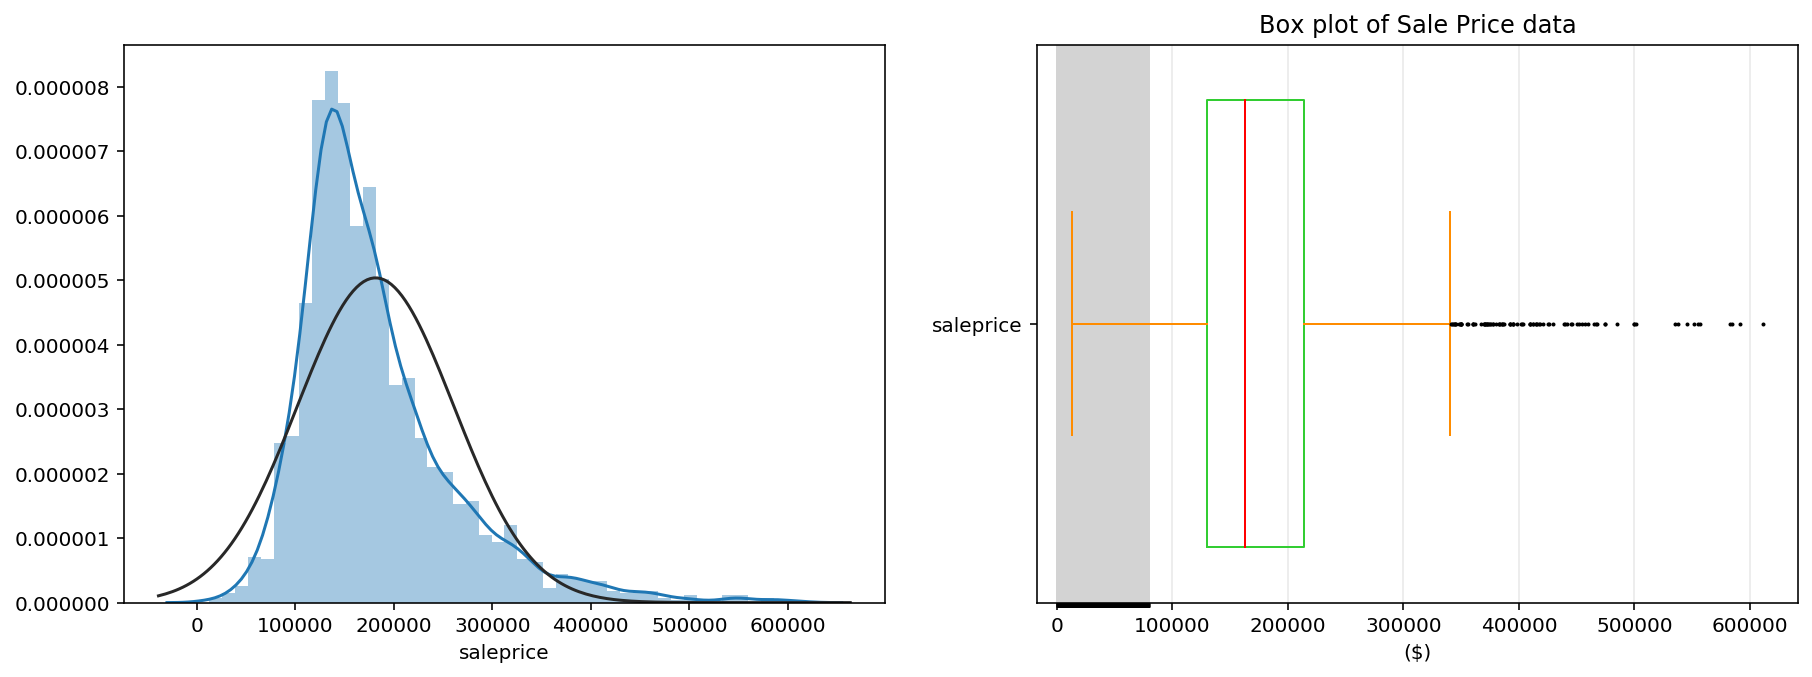

In [20]:
# Let's plot a histogram overlayed with a normal distribution curve for saleprice to see whether
# saleprice is normal or not ie, whether the distribution conforms to LINE assumption.
fig, axs = plt.subplots(ncols=2, figsize = (15,5))
plt.subplots_adjust(top=0.9)
#fig.suptitle('Sales Price')
sns.distplot(train['saleprice'], fit=norm, ax=axs[0])
#sns.boxplot(train['saleprice'], ax=axs[1]);

# Define chart title, colors and flierprops dicts
chart_title = 'Box plot of Sale Price data'
colors = dict(boxes = 'limegreen', whiskers = 'darkorange', medians='red', caps='darkorange')
flierprops = dict(marker='o', markerfacecolor='k', markersize=1)

# Display box plot of SalePrice data
ax = train.loc[:,['saleprice']].plot.box(widths = 0.8, vert=False, title = chart_title, 
                                            color=colors, whis=1.5, flierprops=flierprops, ax=axs[1])

# Add a vertical grid to the plot, but make it light in color
ax.xaxis.grid(True, linestyle='-', which='both', color='lightgrey', alpha=0.5)
ax.set_xticks(range(0,80000,50), minor=True)
ax.set_xlabel('($)');

# The histogram indicates saleprice is not normal, It shows 'peakedness' (kurtosis), positively skewed
# and does not follow the diagonal line. Postively skewed means not many people can afford 
# highly priced property ie, falls on the long tail on the right. From the plot, majority buys average
# priced properties between $100k to $250k range.

# The boxplot shows there are a handful of properties sold above the maximum values and 
# there are quite a number of outliers.


- Histogram and boxplot confirm Sale Price data is right (positively) skewed.
- There are a handful of outliers i.e. sales prices greater than 1.5 times the IQR above the 75th percentile. 2 of these outliers are are considerably higher than the sales prices of all other properties. Let's investigate further.

In [21]:
# Define upper_outlier_fence (i.e. 1.5 times the IQR above Quartile3)
iqr_sale_price = train['saleprice'].describe()[6] - train['saleprice'].describe()[4]
q3_sale_price = train['saleprice'][6]
upper_outlier_fence = 1.5 * iqr_sale_price + q3_sale_price

# Print number of sales prices with values exceeded the upper outlier fence
filt = train['saleprice'] > upper_outlier_fence
print(f"There are {filt.sum()} houses with sales prices potentialy considered as outliers \
(ie. > ${int(upper_outlier_fence)}).")

There are 265 houses with sales prices potentialy considered as outliers (ie. > $266262).


### Examine numeric features

In [22]:
# Calculate the age of the property sold using year_built and year_remod/add. 
# Place the results in new columns for train and test datasets.
# We'll drop year_built and year_remod/add columns.

# Calculate the age of the house when sold
train['age_year_sold'] = ((train.yr_sold + (train.mo_sold-1)/12.) - train.year_built).astype(int)
test['age_year_sold'] = ((test.yr_sold + (test.mo_sold-1)/12.) - test.year_built).astype(int)

# Calculate the age of house remodel when sold
train['remod_age_sold'] = train['yr_sold'] - train['year_remod/add']
test['remod_age_sold'] = test['yr_sold'] - test['year_remod/add']

In [23]:
# Feature engineer another new column call 'garage' by multiplying garage_cars and garage_area, and will drop these 2 features.
train['garage'] = train['garage_cars'] * train['garage_area']
test['garage'] = test['garage_cars'] * test['garage_area']

In [24]:
print(train.shape)
train.head(1) # Check to ensure 2 new columns are added to train and test datasets

(2051, 84)


id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   

  lot_shape land_contour utilities lot_config land_slope neighborhood  \
0       IR1          Lvl    AllPub    CulDSac        Gtl       Sawyer   

  condition_1 condition_2 bldg_type house_style  overall_qual  overall_cond  \
0        RRAe        Norm      1Fam      2Story             6             8   

   year_built  year_remod/add roof_style roof_matl exterior_1st exterior_2nd  \
0        1976            2005      Gable   CompShg      HdBoard      Plywood   

  mas_vnr_type  mas_vnr_area exter_qual exter_cond foundation bsmt_qual  \
0      BrkFace         289.0         Gd         TA     CBlock        TA   

  bsmt_cond bsmt_exposure bsmtfin_type_1  bsmtfin_sf_1 bsmtfin_type_2  \
0        TA            No            GLQ         533.0            Unf   

   bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf heating heating_qc central_air  \
0           0.0        192.0          725.0    GasA         Ex           Y   

  electrical  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0      SBrkr         725         754                0         1479   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0             0.0             0.0          2          1              3   

   kitchen_abvgr kitchen_qual  totrms_abvgrd functional  fireplaces  \
0              1           Gd              6        Typ           0   

  fireplace_qu garage_type  garage_yr_blt garage_finish  garage_cars  \
0          NaN      Attchd         1976.0           RFn          2.0   

   garage_area garage_qual garage_cond paved_drive  wood_deck_sf  \
0        475.0          TA          TA           Y             0   

   open_porch_sf  enclosed_porch  3ssn_porch  screen_porch  pool_area pool_qc  \
0             44               0           0             0          0     NaN   

  fence misc_feature  misc_val  mo_sold  yr_sold sale_type  saleprice  \
0   NaN          NaN         0        3     2010       WD      130500   

   age_year_sold  remod_age_sold  garage  
0             34               5   950.0

In [25]:
print(test.shape)
test.head(1) # Check to ensure 2 new columns are added to train and test datasets

(879, 83)


id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street  \
0  2658  902301120          190        RM          69.0      9142   Pave   

  alley lot_shape land_contour utilities lot_config land_slope neighborhood  \
0  Grvl       Reg          Lvl    AllPub     Inside        Gtl      OldTown   

  condition_1 condition_2 bldg_type house_style  overall_qual  overall_cond  \
0        Norm        Norm    2fmCon      2Story             6             8   

   year_built  year_remod/add roof_style roof_matl exterior_1st exterior_2nd  \
0        1910            1950      Gable   CompShg      AsbShng      AsbShng   

  mas_vnr_type  mas_vnr_area exter_qual exter_cond foundation bsmt_qual  \
0         None           0.0         TA         Fa      Stone        Fa   

  bsmt_cond bsmt_exposure bsmtfin_type_1  bsmtfin_sf_1 bsmtfin_type_2  \
0        TA            No            Unf             0            Unf   

   bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf heating heating_qc central_air  \
0             0         1020           1020    GasA         Gd           N   

  electrical  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0      FuseP         908        1020                0         1928   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0               0               0          2          0              4   

   kitchen_abvgr kitchen_qual  totrms_abvgrd functional  fireplaces  \
0              2           Fa              9        Typ           0   

  fireplace_qu garage_type  garage_yr_blt garage_finish  garage_cars  \
0          NaN      Detchd         1910.0           Unf            1   

   garage_area garage_qual garage_cond paved_drive  wood_deck_sf  \
0          440          Po          Po           Y             0   

   open_porch_sf  enclosed_porch  3ssn_porch  screen_porch  pool_area pool_qc  \
0             60             112           0             0          0     NaN   

  fence misc_feature  misc_val  mo_sold  yr_sold sale_type  age_year_sold  \
0   NaN          NaN         0        4     2006       WD              96   

   remod_age_sold  garage  
0              56     440

### Let's dive deeper to examine the relationship between independent numeric features using plots such as heatmap.

In [26]:
# Define function to generate a correlation heatmap, accepting a DF and correlation method as arguments

def correlation_heat_map(df, corr_method):
    '''This function accepts a dataframe and correlation method string (e.g. 'pearson' or 
    'spearman') and displays the correlation heatmap for the numeric data within the dataframe'''
    
    # Define correlation dataframe, using the corr_method argument
    corrs = df.corr(method = corr_method)

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(40,40))
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Define title string
    title = f'Heatmap of {corr_method} correlation between numeric fixed features and sales price'
    
    # Plot the heatmap with seaborn
    ax = sns.heatmap(corrs, mask=mask, annot=True, fmt='.2f', annot_kws={'size':18},
                     cmap='RdBu_r', center=0, vmin=-1, vmax=1, cbar_kws={'shrink': 0.8})
    ax.set_title(title, fontsize=28)
    
    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=20, rotation=90)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=20, rotation=0)
    
    # Change font size of colormap
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=20) 
    plt.show() 

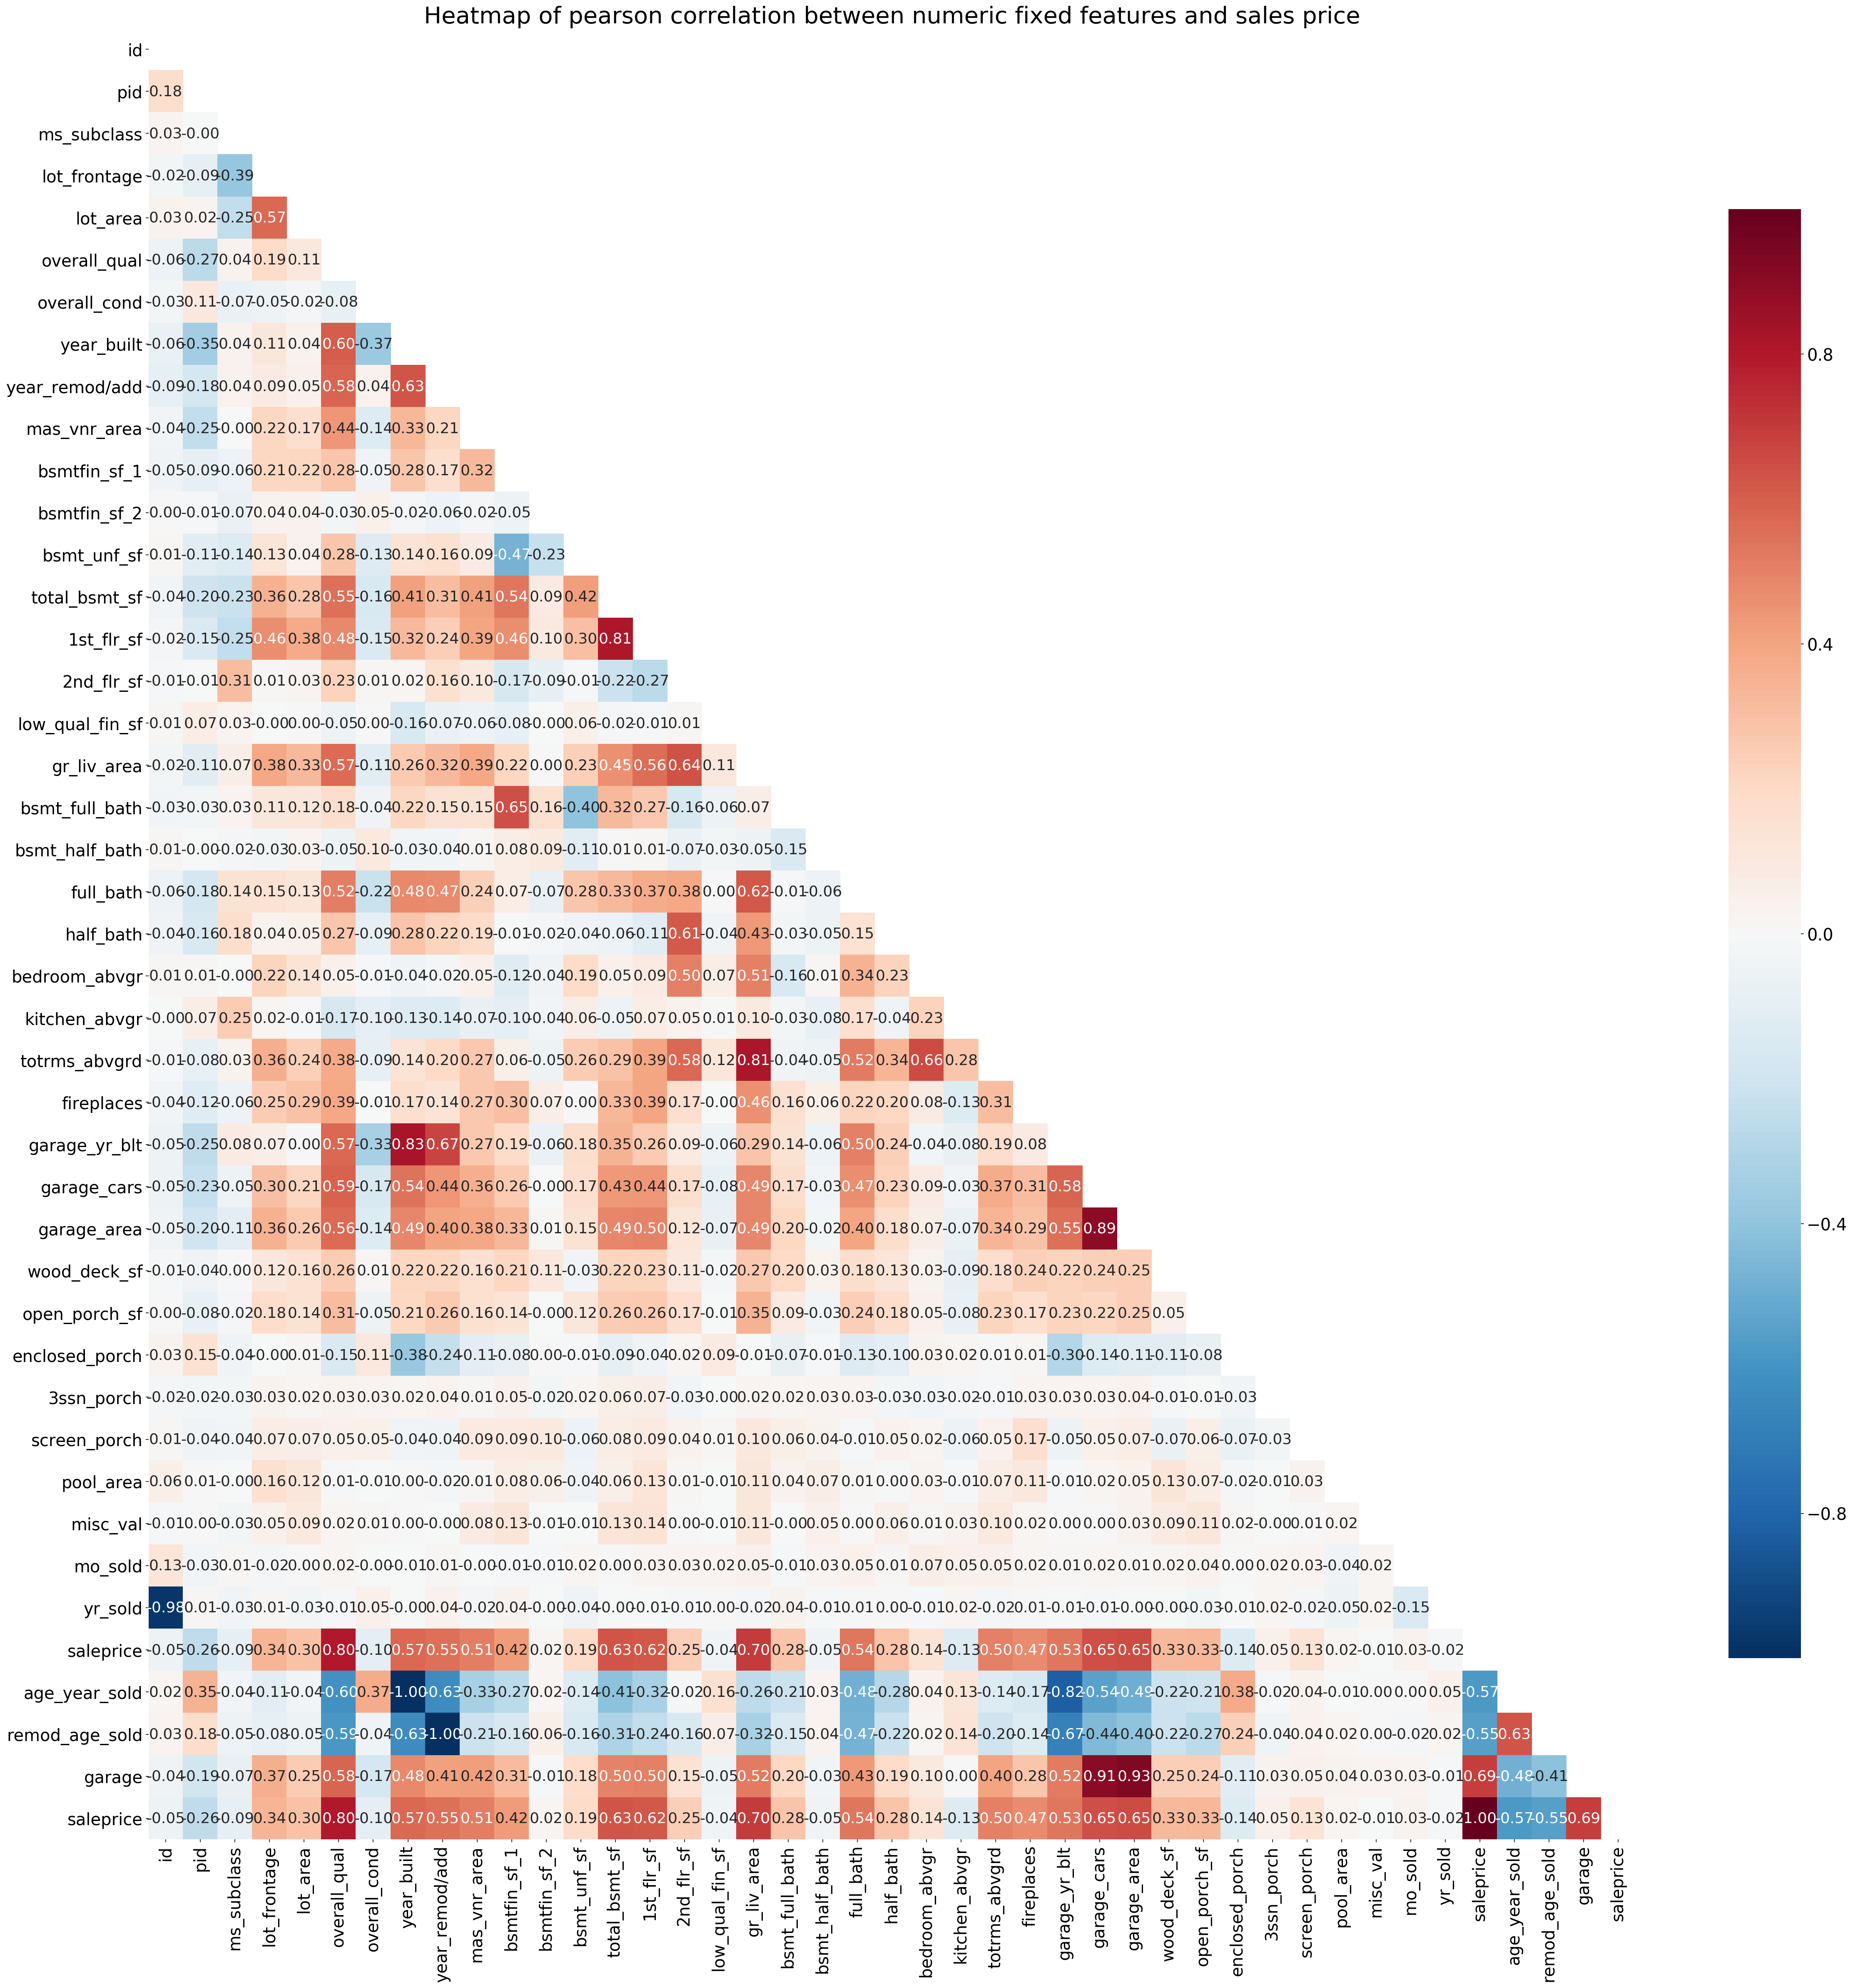

In [27]:
# Call function to generate pearson correlation heatmap for numeric, fixed feature data
# concatenated with SalePrice
correlation_heat_map(pd.concat([train, train['saleprice']], axis = 1), 'pearson')

# Looks like there are many clusters of features that show strong correlation but may be exhibiting multicollinearity
# There are quite a lot of features that has positive correlations with sales eg, gr_live_area, totalbsmtsf, overall_qual.
# It is not surprising to see that overall quality is negatively correlated to year_built ie, the older the building
#   the lower the overall quality.

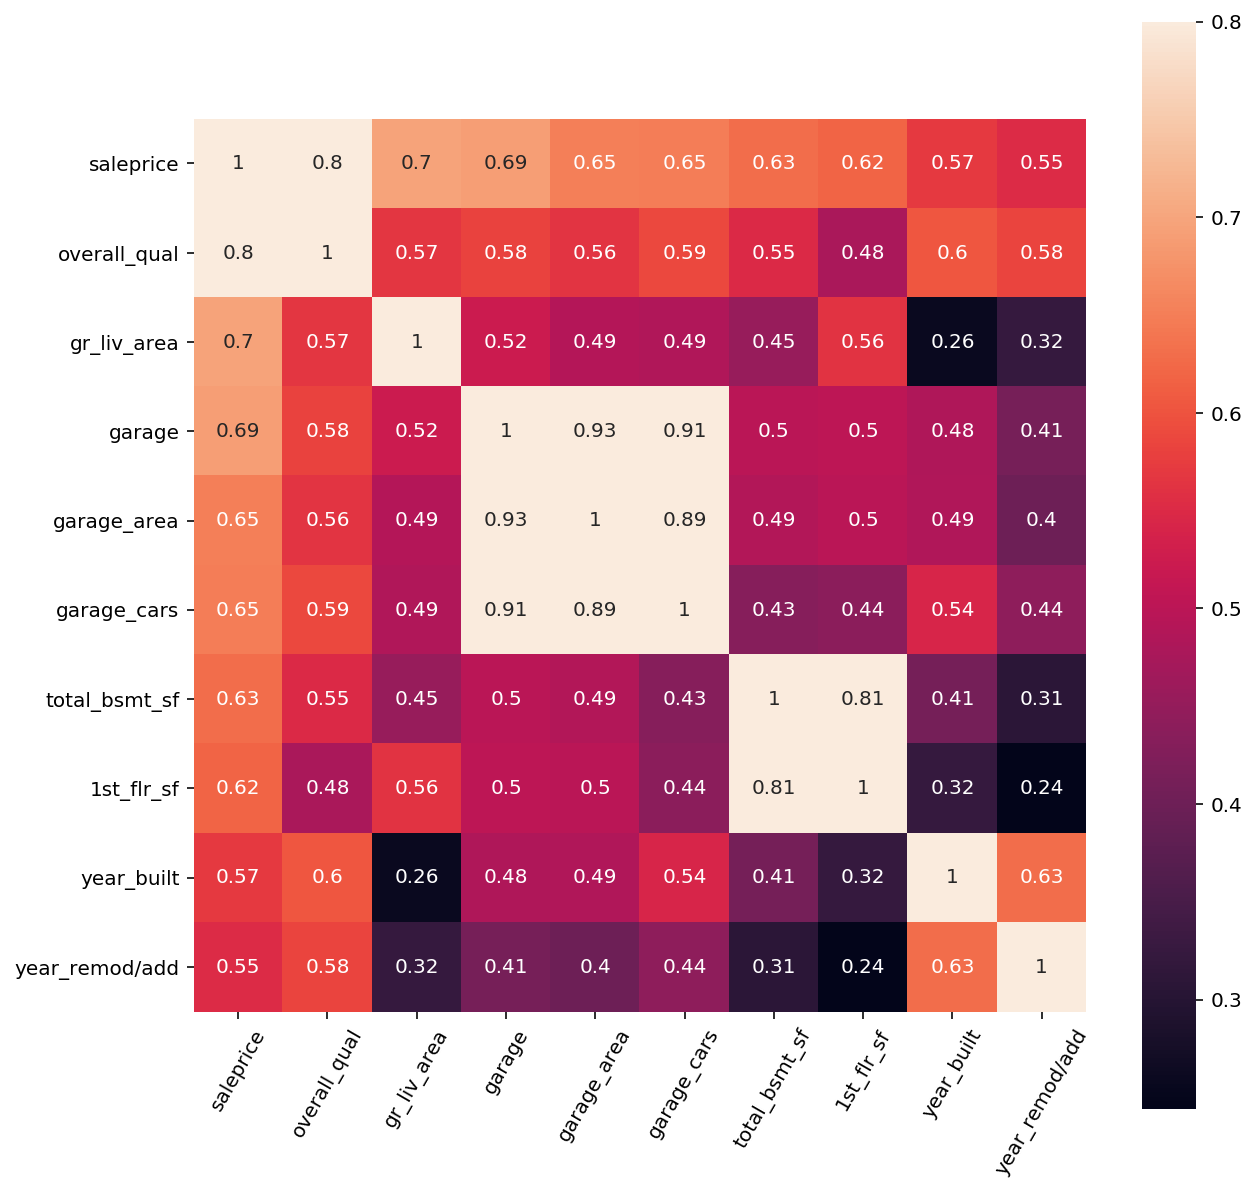

In [28]:
# Let's zoom in to see the 10 features with the highest correlation matrix with saleprice.
# We will examine the correlation bewteen these 9 features and saleprice in more detail.
k = 10
cols = train.corr().nlargest(k, 'saleprice')['saleprice'].index
train[cols].corr()
f, ax = plt.subplots(figsize=(10, 10))
#ax.set_xticklabels(ax.get_xticklabels(), rotation=60)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), rotation=60)
sns.heatmap(train[cols].corr(), vmax=.8, square=True, annot=True);

9 Features with strong correlation with saleprice.
- overall_qual   : 0.80
- gr_liv_area (0.70)    : Above grade (ground) living area square feet
- garage_area (0.65)   : Size of garage in square feet
- garage_cars (0.65)   : Size of garage in car capacity
- total_bsmt_sf (0.63)  : Total Basement square feet
- 1st_flr_sf (0.62)     : First floor square feet
- year_built/ year_remod/add (0.56/ 0.54) (note: we already feature engineered 2 columns to conver the year to age.
- full_bath (0.54)     : Full bathrooms above grade

Let's examine the intercorrelations between these variables:
- year_built/ year_remod/add has a relatively high correlation (0.56/ 0.54 respectively) with each other hence, only 1 of these fields will be included in the model. As year_remod/add appears less correlated with other variables, so it we will choose this - even though its correlation with sales price is slightly less than year_built.
- total_bsmt_sf is highly correlated with 1st_flr_sf (0.63).  We'll include total_bsmt_sf in the model.
- garage_cars and garage_area have an undeniably high correlation (0.89). Obviously, garage area is where car park lot is located and car park lots is meant for cars. We'll only include garage_cars to avoid multicollinearity.

There are many more features are related with one another. We'll look into it in the features engineering section below.

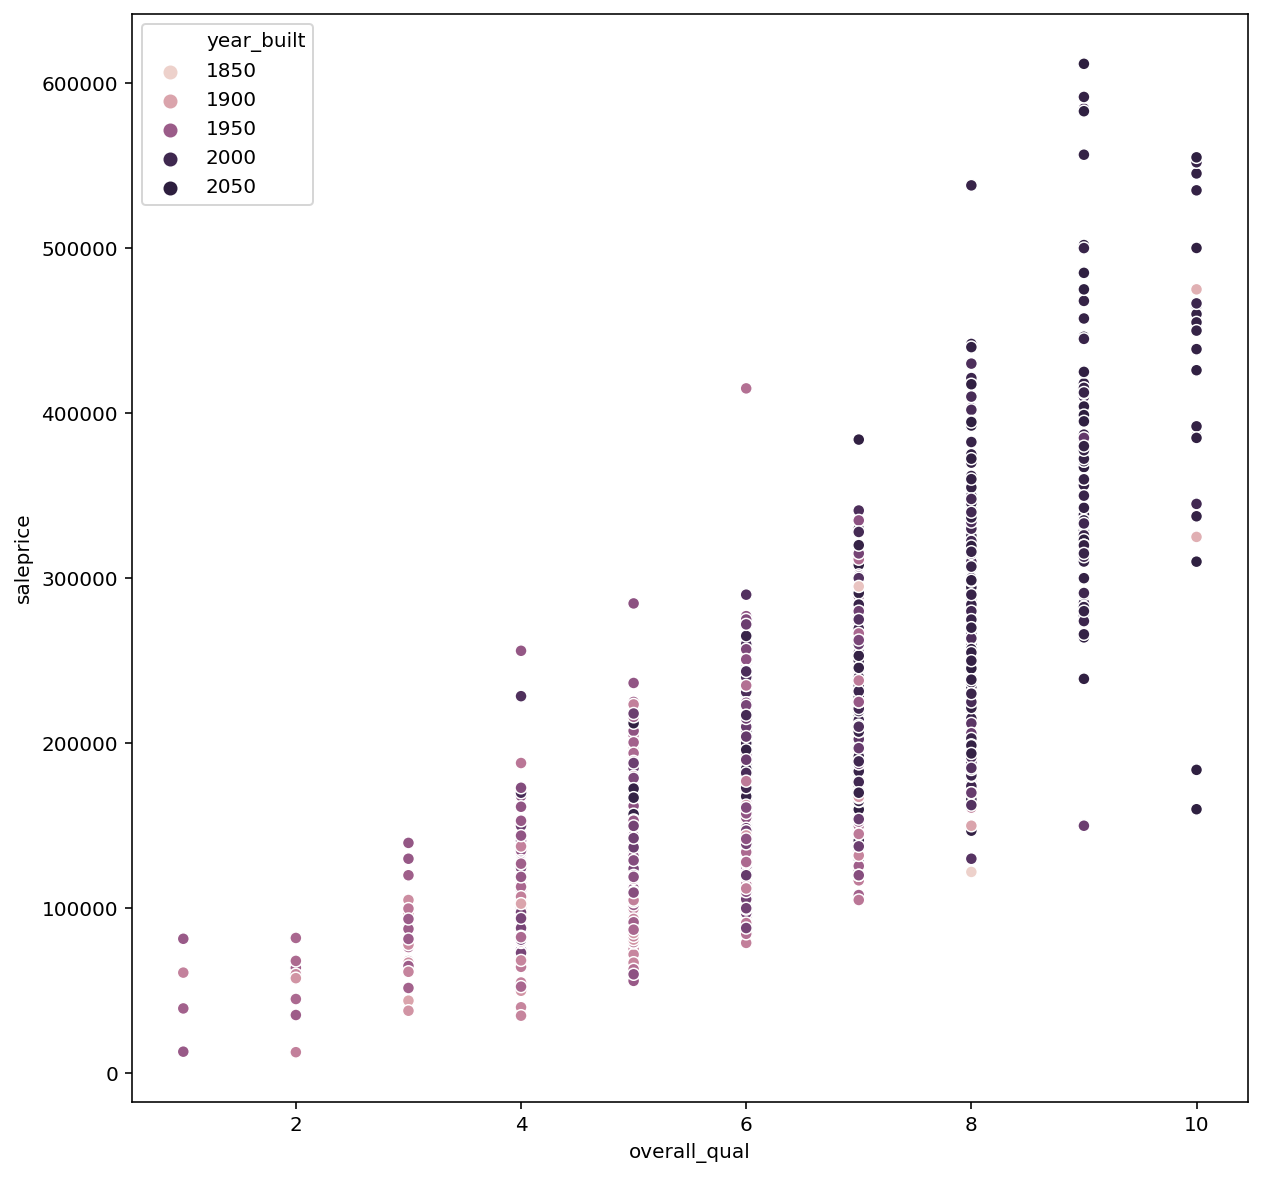

In [29]:
# Before we examine the 9 features, let's take a quick peek at the correlation between saleprice and overall_qual. 
# Clearly, there is a positive correlation between saleprice and overall quality. In addition to that, newer buildings
# are fetching a higher price and the trend is continue to be so.
plt.figure(figsize = (10,10))
ax = sns.scatterplot(x="overall_qual", y="saleprice", hue="year_built", data=train)
# People are willing to pay a higher price for properties that are newer. 

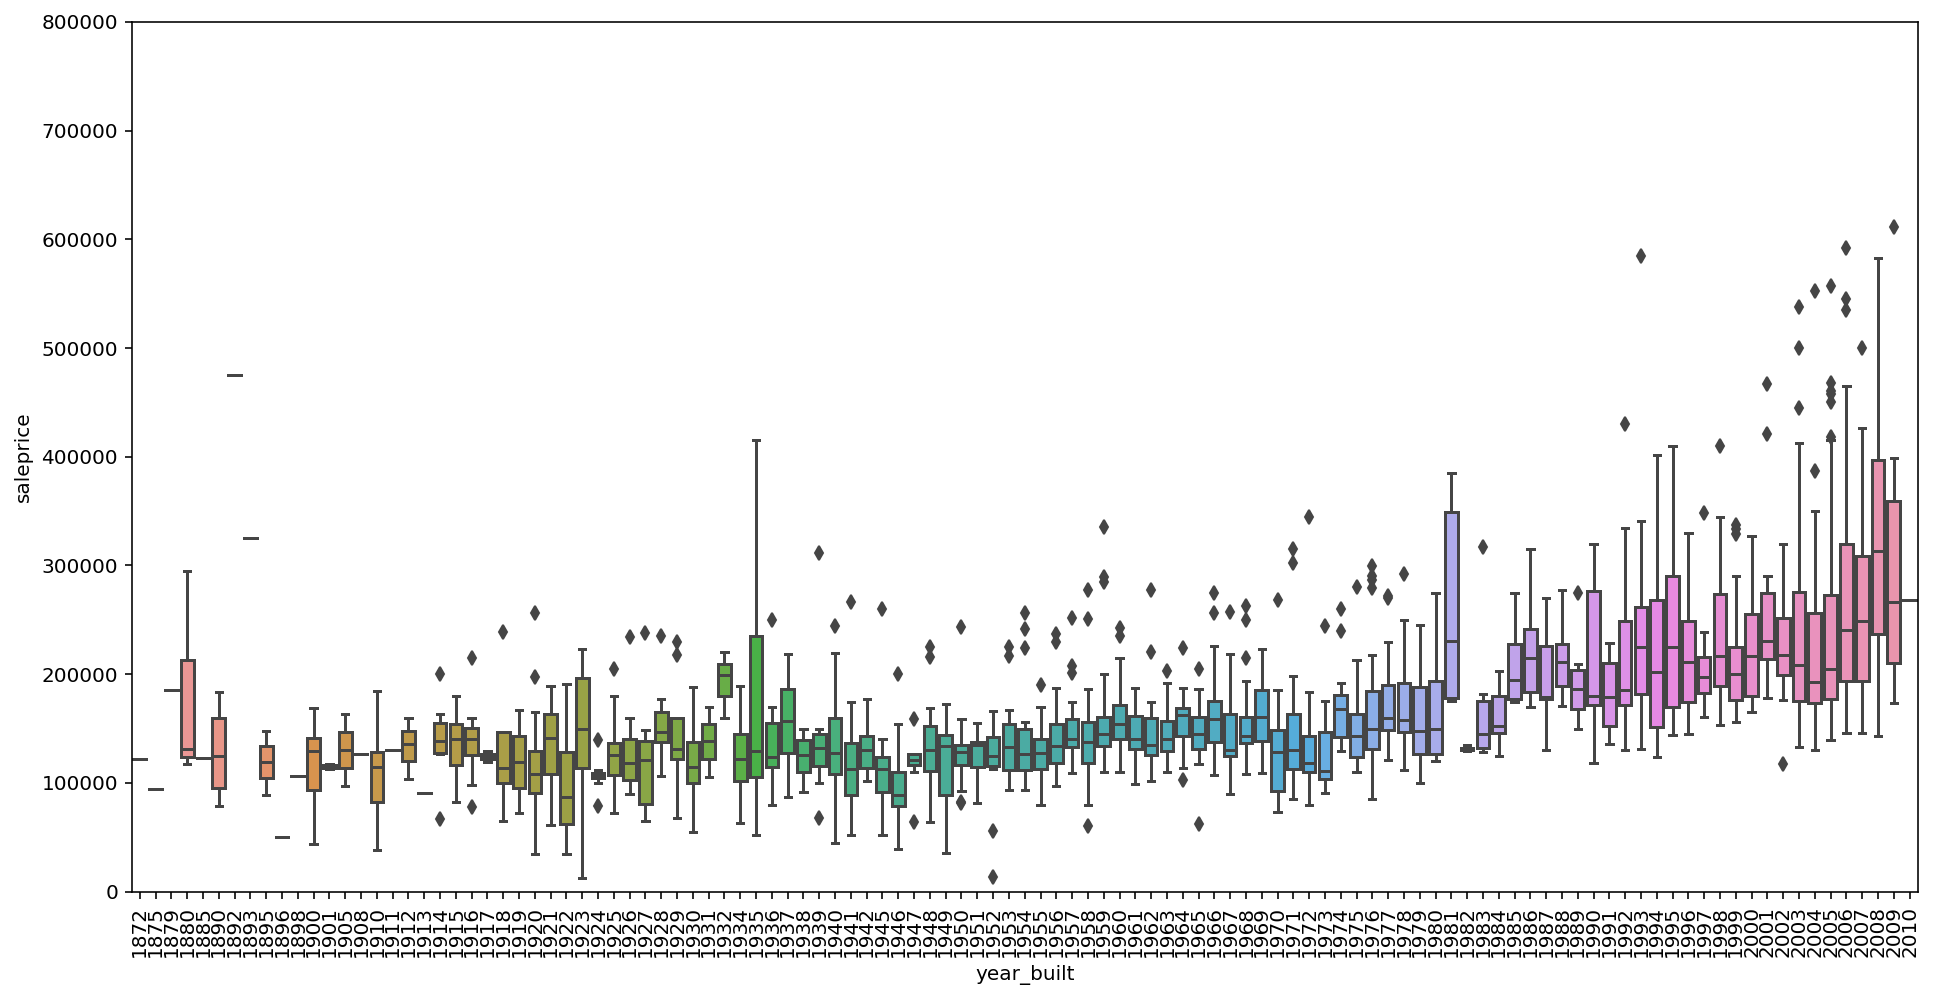

In [30]:
# A boxplot showing clearly newer properties are fetching higher price and increasing 
# at an exponential rate in the past 2 decades.
plt.figure(figsize = (16, 8))
fig = sns.boxplot(x='year_built', y = "saleprice", data = train)
fig.axis(ymin=0, ymax=800000)
plt.xticks(rotation=90);

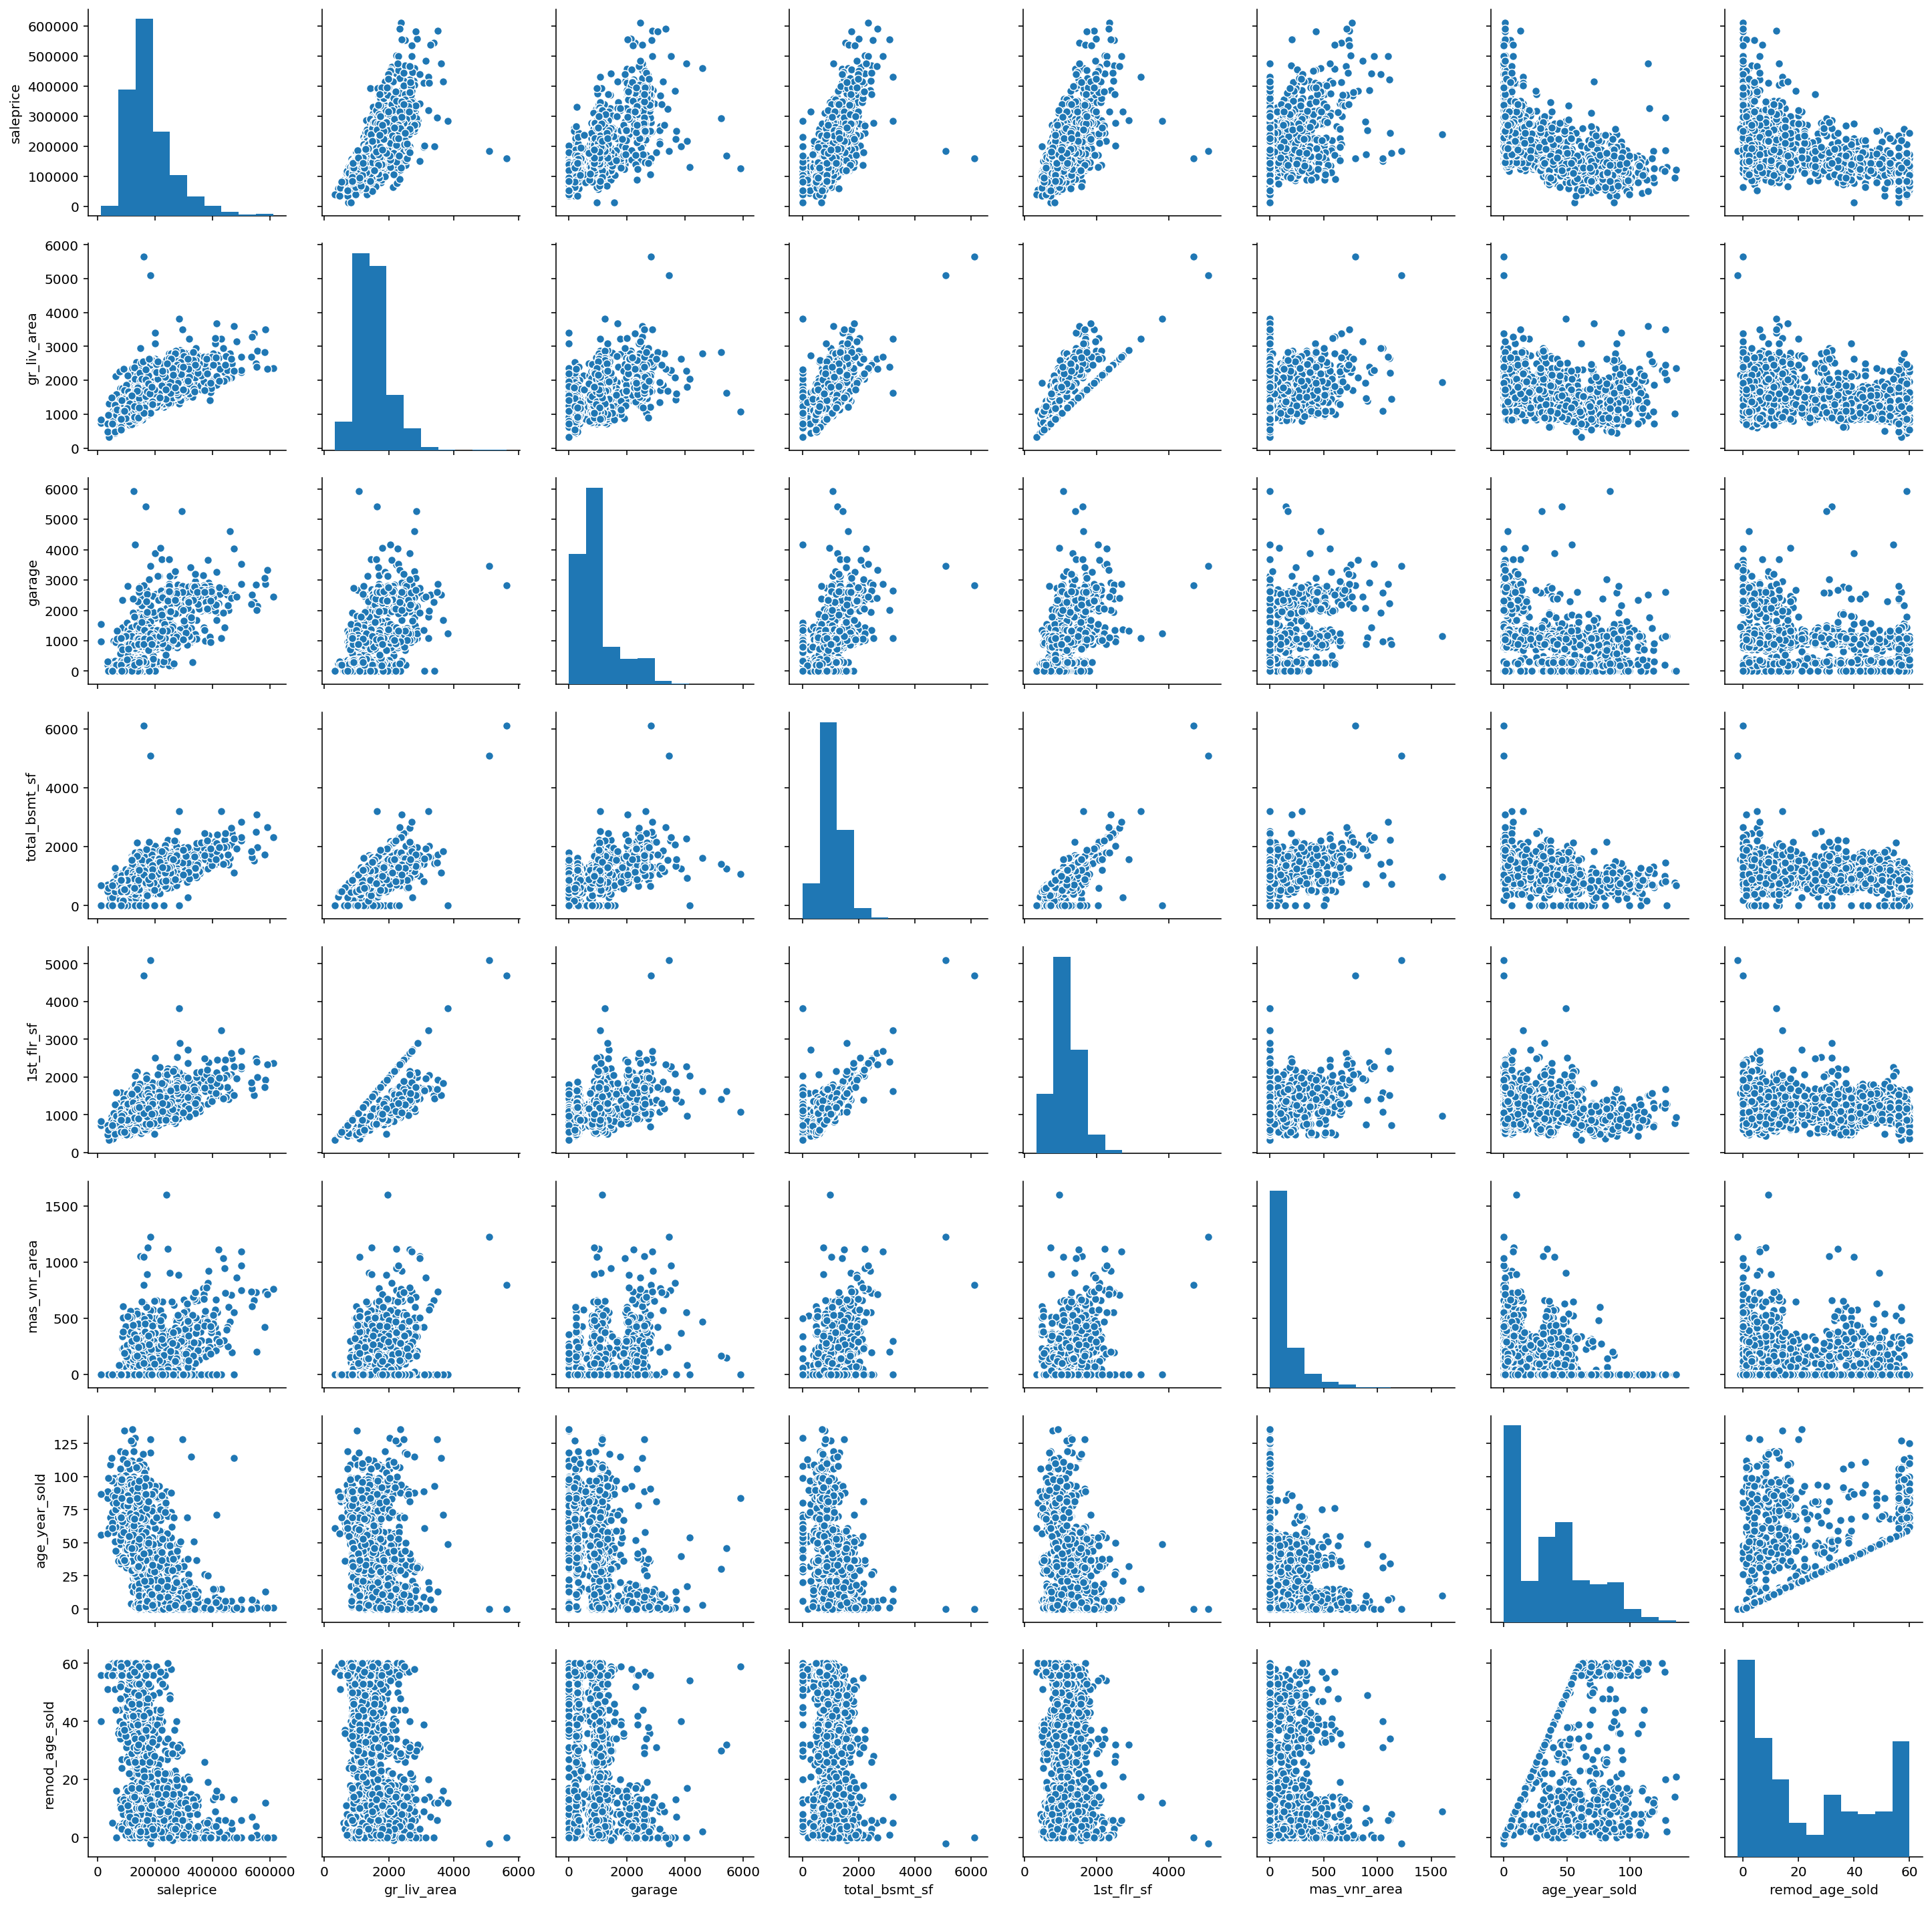

In [31]:
# Let's do Scatterplots pair with saleprice and features shown in the simplified heatmap above to see the correlation
# amongst them excluding features used for feature engineering (year_build, year_remod/add, garage_cars and garage_area and
# replace them with age_year_sold, remod_age_sold and garage. to avoid multicollinearity.
cols = ['saleprice', 'gr_liv_area', 'garage', 'total_bsmt_sf', '1st_flr_sf', 'mas_vnr_area', 'age_year_sold', 'remod_age_sold']
sns.pairplot(train[cols], size = 2.5);

# The pair plots clearly indicating there are positive correlations between saleprice and the features it was plotted against
# except with age_year_sold and remod_age_sold which is negatively correlated.

# Let's take a closer look with some of the features that have a positive correlation with saleprice.

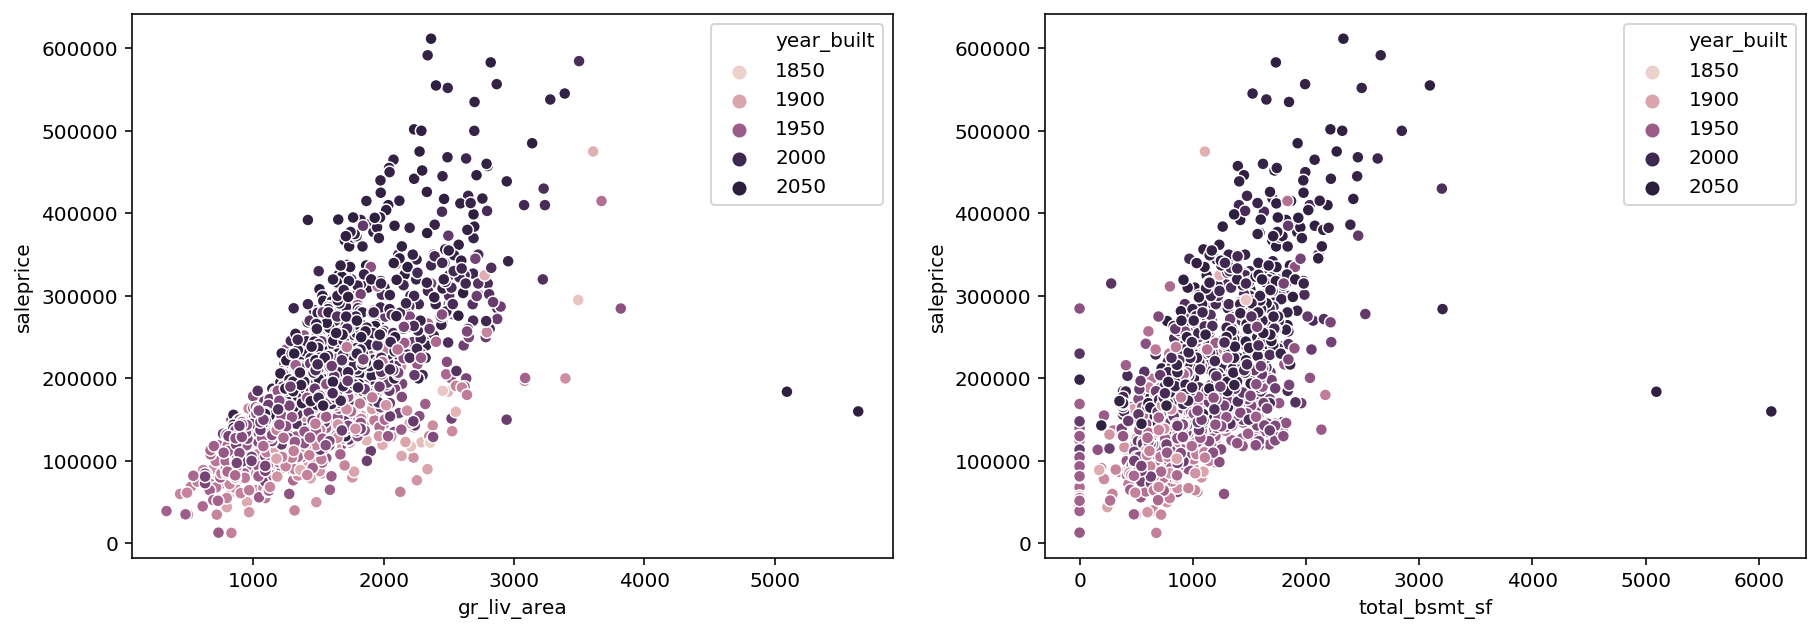

In [32]:
# Ground living area, total basement area, garage_cars and number of cars are positvely correlated to saleprice
fig, axs = plt.subplots(ncols=2, figsize = (15,5))
sns.scatterplot(x="gr_liv_area", y="saleprice", hue="year_built", data=train, ax=axs[0])
sns.scatterplot(x="total_bsmt_sf", y="saleprice", hue="year_built", data=train, ax=axs[1]);

# It is interesting to see that Law of Diminishing Marginal Returns occrured for garage car which makes sense because 
# how many cars does a family own. It peaks at 3 car park lots and price dropped drastically for property with more 
# than 3 car park lots. It can be seen that garage_cars and garage_areas are correlated thus, it makes sense to combine 
# the 2 features.

# Similarly, more than 2 full bath, price will starts to come down. Another observation of saleprice was that, 
# there has been an increaing trend over the years but it is increasing at an exponential rate in the recent years.

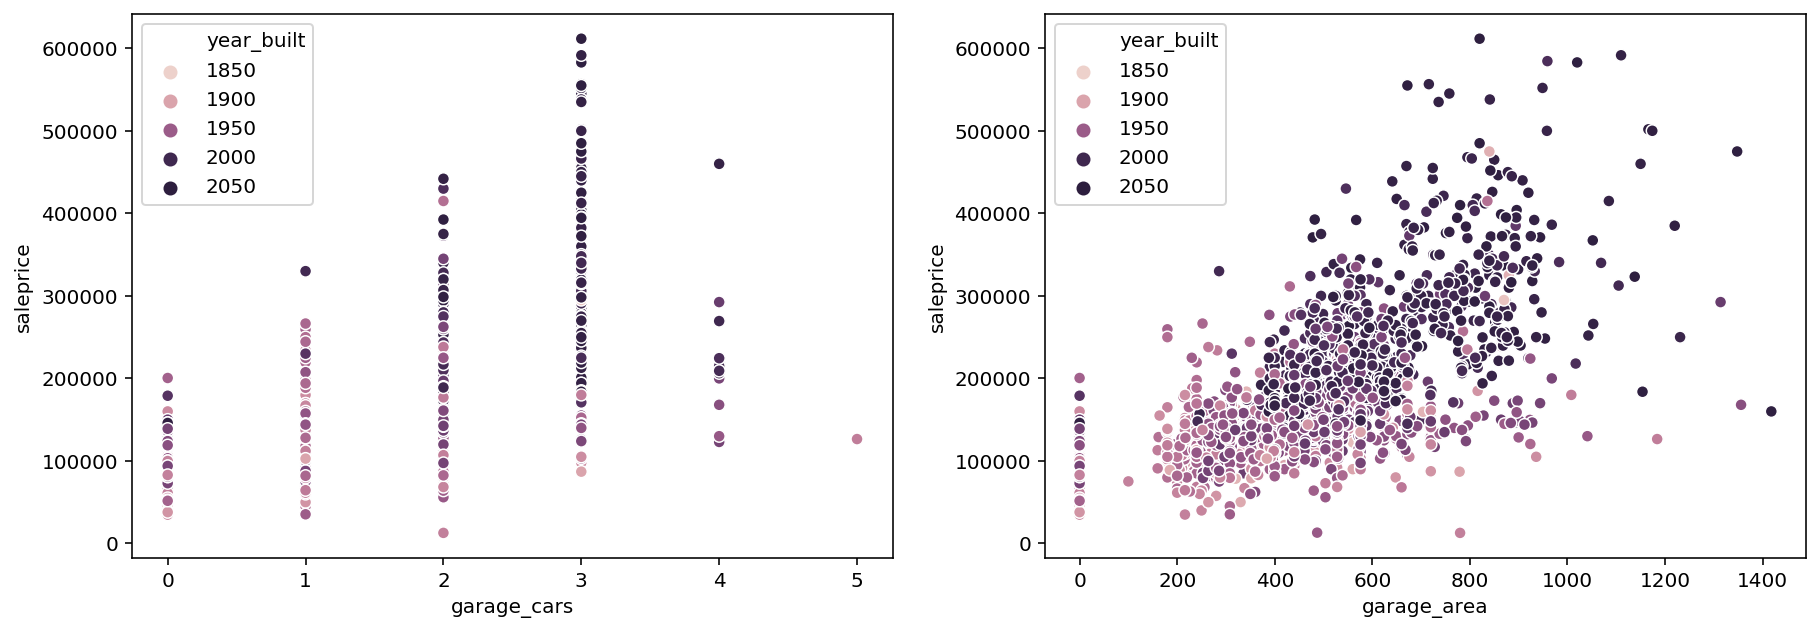

In [33]:
# As mentioned above, 3 car park lots is the sweet spot. Any thing more than that is counter-productive.
fig, axs = plt.subplots(ncols=2, figsize = (15,5))
sns.scatterplot(x="garage_cars", y="saleprice", hue="year_built", data=train, ax=axs[0])
sns.scatterplot(x="garage_area", y="saleprice", hue="year_built", data=train, ax=axs[1])
plt.legend(loc='upper left');

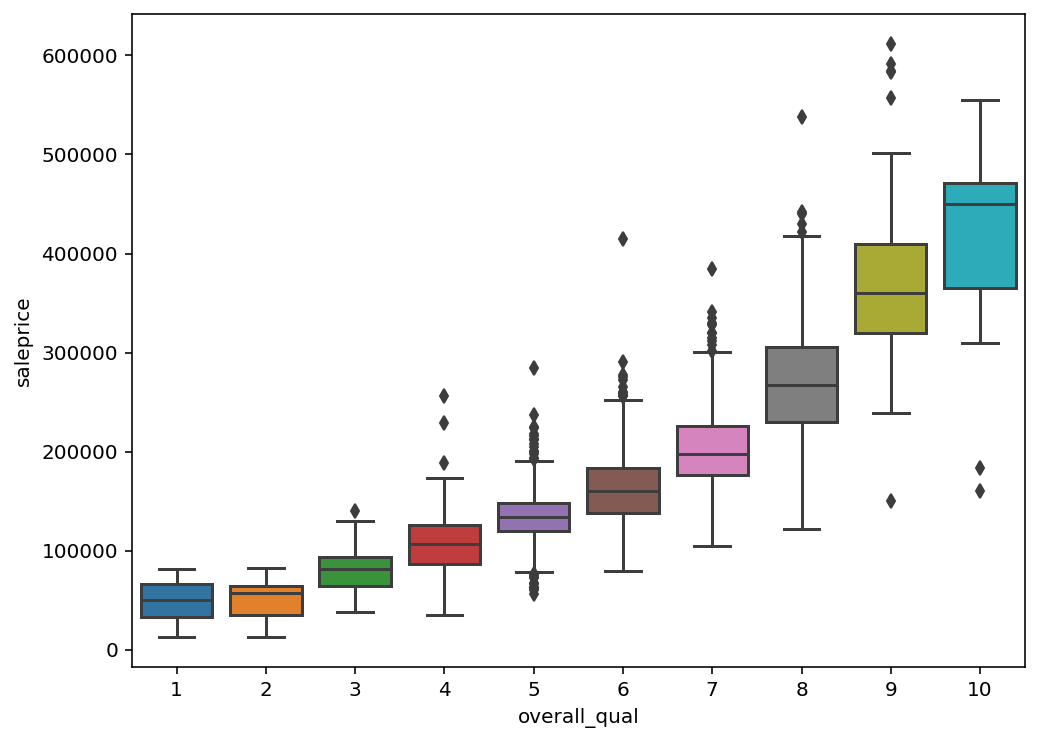

In [34]:
# Clearly, higher overall quality leads to higher saleprice 
plt.figure(figsize =(8, 6))
fig = sns.boxplot(x='overall_qual', y="saleprice", data = train);

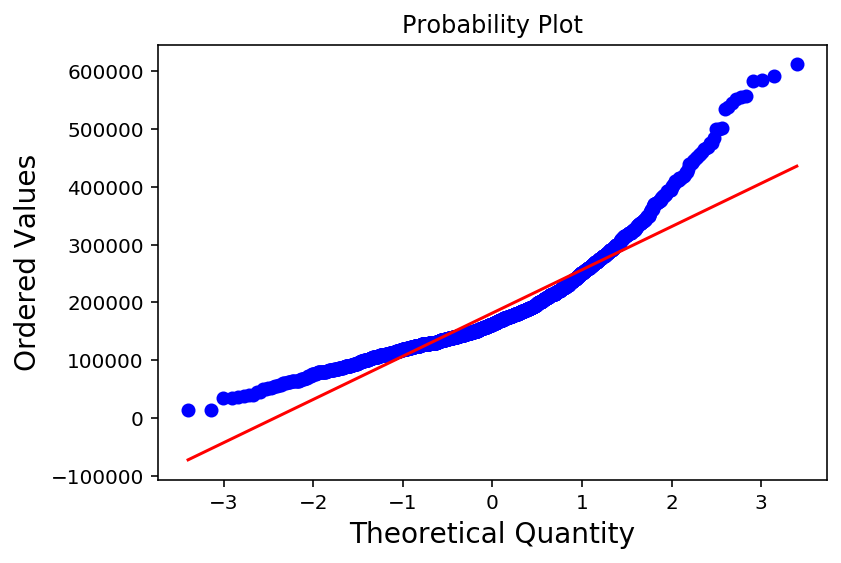

In [35]:
# Normal probability plot - saleprice doesn't follow the diagonal line means data is not normal.
# To make the saleprice normal, a simple data transformation can solve the problem. 
# In case of positive skewness, log transformations usually works well.
fig = plt.figure()
res = stats.probplot(train['saleprice'], plot=plt, )
plt.xlabel('Theoretical Quantity', fontsize=14)
plt.ylabel('Ordered Values', fontsize=14);

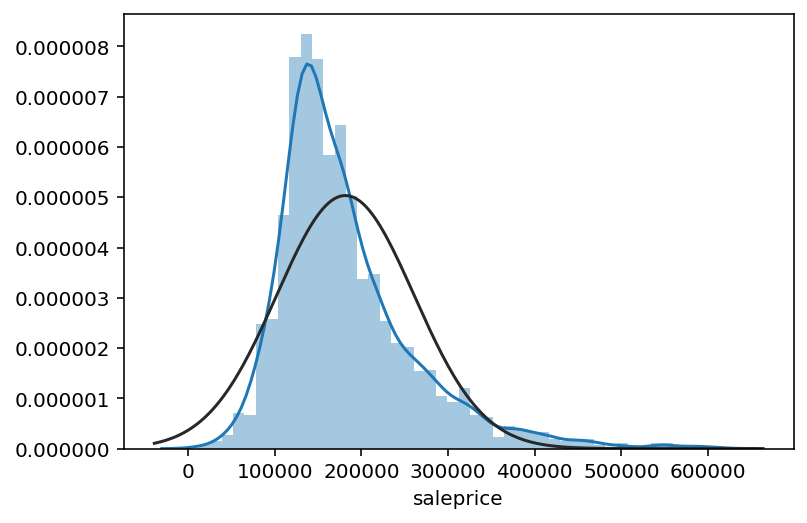

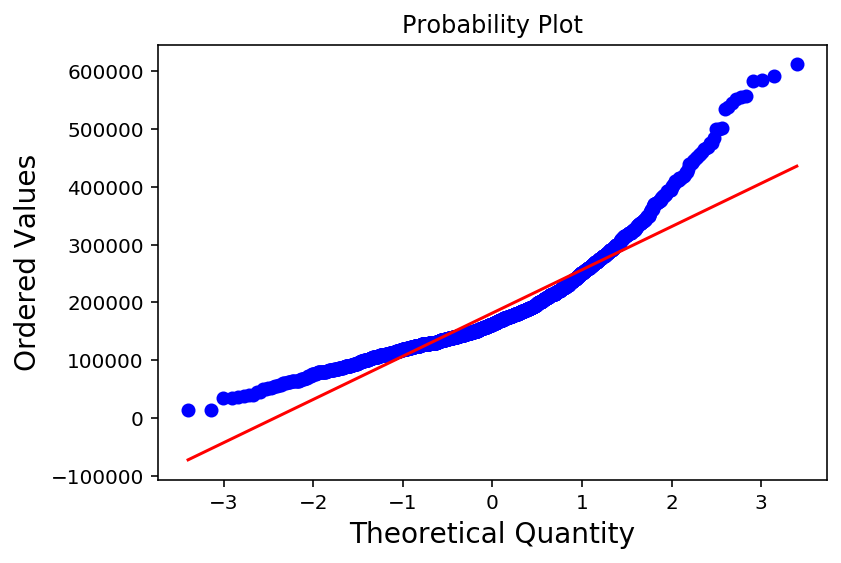

In [36]:
# This function will plot a histogram and a probability plot of the parameter passed to it
def hist_norm_prob_plot(feature):
    sns.distplot(train[feature], fit=norm);
    fig = plt.figure()
    res = stats.probplot(train[feature], plot=plt)
    plt.xlabel('Theoretical Quantity', fontsize=14)
    plt.ylabel('Ordered Values', fontsize=14);

# Histogram and normal probability plot for saleprice
hist_norm_prob_plot('saleprice')  

# That's more like it! saleprice is now normal after the log transformation

#### Analyse selected numeric features based on the a correlation with sales.

In [37]:
# Define dictionary of column indexes for ease of identification
col_indexes = dict(enumerate(train.columns)) 
print(col_indexes)

{0: 'id', 1: 'pid', 2: 'ms_subclass', 3: 'ms_zoning', 4: 'lot_frontage', 5: 'lot_area', 6: 'street', 7: 'alley', 8: 'lot_shape', 9: 'land_contour', 10: 'utilities', 11: 'lot_config', 12: 'land_slope', 13: 'neighborhood', 14: 'condition_1', 15: 'condition_2', 16: 'bldg_type', 17: 'house_style', 18: 'overall_qual', 19: 'overall_cond', 20: 'year_built', 21: 'year_remod/add', 22: 'roof_style', 23: 'roof_matl', 24: 'exterior_1st', 25: 'exterior_2nd', 26: 'mas_vnr_type', 27: 'mas_vnr_area', 28: 'exter_qual', 29: 'exter_cond', 30: 'foundation', 31: 'bsmt_qual', 32: 'bsmt_cond', 33: 'bsmt_exposure', 34: 'bsmtfin_type_1', 35: 'bsmtfin_sf_1', 36: 'bsmtfin_type_2', 37: 'bsmtfin_sf_2', 38: 'bsmt_unf_sf', 39: 'total_bsmt_sf', 40: 'heating', 41: 'heating_qc', 42: 'central_air', 43: 'electrical', 44: '1st_flr_sf', 45: '2nd_flr_sf', 46: 'low_qual_fin_sf', 47: 'gr_liv_area', 48: 'bsmt_full_bath', 49: 'bsmt_half_bath', 50: 'full_bath', 51: 'half_bath', 52: 'bedroom_abvgr', 53: 'kitchen_abvgr', 54: 'kitc

In [38]:
# Select list of column of indexes of numeric, fixed features of interest for predicting sales price, 
# based on col_indexes dictionary above
features_col_index = [0, 4, 5, 27, 35, 38, 39, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 
                      55, 57, 67, 68, 69, 70, 72, 76, 81, 82, 83, 80]

# Define data frame with quantifable, fixed features for residential properties only for training dataset
train_ff = train.iloc[:,features_col_index]

In [39]:
print(f'Train shape: {train.shape}, Train_ff Shape: {train_ff.shape}')
train_ff.head()

Train shape: (2051, 84), Train_ff Shape: (2051, 29)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  109           NaN     13517         289.0         533.0        192.0   
1  544          43.0     11492         132.0         637.0        276.0   
2  153          68.0      7922           0.0         731.0        326.0   
3  318          73.0      9802           0.0           0.0        384.0   
4  255          82.0     14235           0.0           0.0        676.0   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0          725.0         725         754                0         1479   
1          913.0         913        1209                0         2122   
2         1057.0        1057           0                0         1057   
3          384.0         744         700                0         1444   
4          676.0         831         614                0         1445   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0             0.0             0.0          2          1              3   
1             1.0             0.0          2          1              4   
2             1.0             0.0          1          0              3   
3             0.0             0.0          2          1              3   
4             0.0             0.0          2          0              3   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0              1              6           0             0             44   
1              1              8           1             0             74   
2              1              5           0             0             52   
3              1              7           0           100              0   
4              1              6           0             0             59   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0               0           0          0         0             34   
1               0           0          0         0             13   
2               0           0          0         0             57   
3               0           0          0         0              4   
4               0           0          0         0            110   

   remod_age_sold  garage  saleprice  
0               5   950.0     130500  
1              12  1118.0     220000  
2               3   246.0     109000  
3               3   800.0     174000  
4              17   968.0     138500

In [40]:
# Inspect selected features for dtype and whether any missing values
train_ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   lot_frontage     1721 non-null   float64
 2   lot_area         2051 non-null   int64  
 3   mas_vnr_area     2029 non-null   float64
 4   bsmtfin_sf_1     2050 non-null   float64
 5   bsmt_unf_sf      2050 non-null   float64
 6   total_bsmt_sf    2050 non-null   float64
 7   1st_flr_sf       2051 non-null   int64  
 8   2nd_flr_sf       2051 non-null   int64  
 9   low_qual_fin_sf  2051 non-null   int64  
 10  gr_liv_area      2051 non-null   int64  
 11  bsmt_full_bath   2049 non-null   float64
 12  bsmt_half_bath   2049 non-null   float64
 13  full_bath        2051 non-null   int64  
 14  half_bath        2051 non-null   int64  
 15  bedroom_abvgr    2051 non-null   int64  
 16  kitchen_abvgr    2051 non-null   int64  
 17  totrms_abvgrd 

In [41]:
# Repeat the selection of numeric feature of interest columns for test datasets
# Define dictionary of column indexes for ease of identification
col_indexes = dict(enumerate(test.columns)) 
print(col_indexes)

{0: 'id', 1: 'pid', 2: 'ms_subclass', 3: 'ms_zoning', 4: 'lot_frontage', 5: 'lot_area', 6: 'street', 7: 'alley', 8: 'lot_shape', 9: 'land_contour', 10: 'utilities', 11: 'lot_config', 12: 'land_slope', 13: 'neighborhood', 14: 'condition_1', 15: 'condition_2', 16: 'bldg_type', 17: 'house_style', 18: 'overall_qual', 19: 'overall_cond', 20: 'year_built', 21: 'year_remod/add', 22: 'roof_style', 23: 'roof_matl', 24: 'exterior_1st', 25: 'exterior_2nd', 26: 'mas_vnr_type', 27: 'mas_vnr_area', 28: 'exter_qual', 29: 'exter_cond', 30: 'foundation', 31: 'bsmt_qual', 32: 'bsmt_cond', 33: 'bsmt_exposure', 34: 'bsmtfin_type_1', 35: 'bsmtfin_sf_1', 36: 'bsmtfin_type_2', 37: 'bsmtfin_sf_2', 38: 'bsmt_unf_sf', 39: 'total_bsmt_sf', 40: 'heating', 41: 'heating_qc', 42: 'central_air', 43: 'electrical', 44: '1st_flr_sf', 45: '2nd_flr_sf', 46: 'low_qual_fin_sf', 47: 'gr_liv_area', 48: 'bsmt_full_bath', 49: 'bsmt_half_bath', 50: 'full_bath', 51: 'half_bath', 52: 'bedroom_abvgr', 53: 'kitchen_abvgr', 54: 'kitc

In [42]:
# Select list of column of indexes of numeric, fixed features of interest for predicting sales price, 
# based on col_indexes dictionary above
features_col_index_test = [0, 4, 5, 27, 35, 38, 39, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 55, 57, 67, 68, 69, 70, 72, 76, 80, 81, 82]

# Define data frame with quantifable, fixed features for residential properties only for testing dataset
test_ff = test.iloc[:,features_col_index_test]

In [43]:
print(f'Test shape: {test.shape}, Test_ff Shape: {test_ff.shape}')
test_ff.head()

Test shape: (879, 83), Test_ff Shape: (879, 28)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  2658          69.0      9142           0.0             0         1020   
1  2718           NaN      9662           0.0             0         1967   
2  2414          58.0     17104           0.0           554          100   
3  1989          60.0      8520           0.0             0          968   
4   625           NaN      9500         247.0           609          785   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0           1020         908        1020                0         1928   
1           1967        1967           0                0         1967   
2            654         664         832                0         1496   
3            968         968           0                0          968   
4           1394        1394           0                0         1394   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0               0               0          2          0              4   
1               0               0          2          0              6   
2               1               0          2          1              3   
3               0               0          1          0              2   
4               1               0          1          1              3   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0              2              9           0             0             60   
1              2             10           0           170              0   
2              1              7           1           100             24   
3              1              5           0             0              0   
4              1              6           2             0             76   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0             112           0          0         0             96   
1               0           0          0         0             29   
2               0           0          0         0              0   
3             184           0          0         0             84   
4               0           0          0         0             46   

   remod_age_sold  garage  
0              56     440  
1              29    1160  
2               0     852  
3               1     960  
4              46    1028

In [44]:
test_ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               879 non-null    int64  
 1   lot_frontage     719 non-null    float64
 2   lot_area         879 non-null    int64  
 3   mas_vnr_area     878 non-null    float64
 4   bsmtfin_sf_1     879 non-null    int64  
 5   bsmt_unf_sf      879 non-null    int64  
 6   total_bsmt_sf    879 non-null    int64  
 7   1st_flr_sf       879 non-null    int64  
 8   2nd_flr_sf       879 non-null    int64  
 9   low_qual_fin_sf  879 non-null    int64  
 10  gr_liv_area      879 non-null    int64  
 11  bsmt_full_bath   879 non-null    int64  
 12  bsmt_half_bath   879 non-null    int64  
 13  full_bath        879 non-null    int64  
 14  half_bath        879 non-null    int64  
 15  bedroom_abvgr    879 non-null    int64  
 16  kitchen_abvgr    879 non-null    int64  
 17  totrms_abvgrd   

# Make a copy of train and test set

In [45]:
# Make a copy of the train and test datasets
train_2 = train_ff.copy()
test_2 = test_ff.copy()

### Data Cleaning - Let the scrubbing begin...

In [46]:
# Display unique values in LotFrontage field
train_ff['lot_frontage'].unique()

array([ nan,  43.,  68.,  73.,  82., 137.,  35.,  70.,  21.,  64., 120.,
        24.,  74.,  93.,  34.,  80.,  71.,  72., 109.,  40., 103., 100.,
        92.,  65.,  75.,  60.,  30.,  79.,  41., 105., 107.,  81.,  36.,
        63.,  32.,  94.,  44.,  50.,  48.,  67.,  88.,  83.,  53.,  58.,
        57.,  52.,  87., 134.,  56.,  54., 140.,  78.,  85.,  90.,  96.,
        62.,  49.,  59., 155.,  91.,  61.,  86., 128.,  77.,  42.,  89.,
        51.,  69.,  55., 112.,  76., 125.,  98., 113., 102.,  22., 122.,
        84., 119., 118.,  66.,  95., 108., 195., 106.,  39., 110., 130.,
        97.,  45.,  37., 123.,  38., 129., 115.,  47., 114., 104.,  46.,
       121., 124., 313., 141., 101.,  99., 160., 174.,  26., 144., 138.,
       111.,  25.,  33., 200., 150., 117., 153., 116., 135.])

In [47]:
# Print min and max values of LotFrontage field
print(np.min(train_ff['lot_frontage']), np.max(train_ff['lot_frontage']))

21.0 313.0


There is no zero lot_frontage values thus these NaNs should be 0 since these houses don't have lot_frontage 
which means no linear feet of street connected to property. Let's investigate the NaN values in the context of all fields within dataset to help understand why they may be NaN.

In [48]:
# Print number of rows with NaN lot_frontage.
filt = train_ff.lot_frontage.isnull()
print(f"{filt.sum()} properties have lot_frontage = NaN")
train_ff[filt].head()

330 properties have lot_frontage = NaN


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0    109           NaN     13517         289.0         533.0        192.0   
7    145           NaN     12160         180.0        1000.0        188.0   
8   1942           NaN     15783           0.0         292.0        632.0   
23    12           NaN      7980           0.0         935.0        233.0   
27  1534           NaN     11700           0.0         606.0        336.0   

    total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0           725.0         725         754                0         1479   
7          1188.0        1188           0                0         1188   
8           924.0         924           0                0          924   
23         1168.0        1187           0                0         1187   
27          942.0        1265         673                0         1938   

    bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0              0.0             0.0          2          1              3   
7              1.0             0.0          1          0              3   
8              0.0             0.0          1          0              2   
23             1.0             0.0          2          0              3   
27             0.0             0.0          2          0              4   

    kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0               1              6           0             0             44   
7               1              6           0             0              0   
8               1              6           0             0            324   
23              1              6           0           483             21   
27              1              7           1             0             40   

    enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0                0           0          0         0             34   
7                0           0          0         0             51   
8                0           0          0       400             55   
23               0           0          0       500             18   
27               0           0          0         0             71   

    remod_age_sold  garage  saleprice  
0                5   950.0     130500  
7               51  1062.0     142000  
8               55   420.0     112500  
23               3   840.0     185000  
27              13   240.0     198000

In [49]:
# Review lot_config of the properties with NaN lot_frontage. Perhaps only Inside lots have null lot_frontage?
# Print lot_config value counts where lot_frontage is NaN
train.loc[filt,'lot_config'].value_counts()

Inside     190
Corner      67
CulDSac     61
FR2         11
FR3          1
Name: lot_config, dtype: int64

Unable to conclude why homes have NaN for lot_frontage. Let's set these to 0, based on an educated guess that these homes do not have street frontage, and the fact that the lot_frontage field doesn't currently contain any 0 values.

In [50]:
# Set NaN LotFrontage values to 0 in all the train and test datasets
train.loc[filt,'lot_frontage'] = 0.

filt = train_ff['lot_frontage'].isnull()
train_ff.loc[filt,'lot_frontage'] = 0.

print(f'lot_frontage now contains {train_ff.lot_frontage.isnull().sum()} NaN values')

lot_frontage now contains 0 NaN values


In [51]:
# Set NaN LotFrontage values to 0 in all the train and test datasets
test.loc[filt,'lot_frontage'] = 0.

filt = test_ff['lot_frontage'].isnull()
test_ff.loc[filt,'lot_frontage'] = 0.

print(f'lot_frontage now contains {test_ff.lot_frontage.isnull().sum()} NaN values')

lot_frontage now contains 0 NaN values


#### Data Cleaning: mas_vnr_area NaN values

In [52]:
# Display house data where MasVnrArea field is NaN
filt = train.mas_vnr_area.isnull()
train[filt].head(3)

id        pid  ms_subclass ms_zoning  lot_frontage  lot_area street  \
22  2393  528142010           60        RL         103.0     12867   Pave   
41  2383  528110050           20        RL         107.0     13891   Pave   
86   539  531371050           20        RL          67.0     10083   Pave   

   alley lot_shape land_contour utilities lot_config land_slope neighborhood  \
22   NaN       IR1          Lvl    AllPub     Corner        Gtl      NridgHt   
41   NaN       Reg          Lvl    AllPub     Inside        Gtl      NridgHt   
86   NaN       Reg          Lvl    AllPub     Inside        Gtl      SawyerW   

   condition_1 condition_2 bldg_type house_style  overall_qual  overall_cond  \
22        Norm        Norm      1Fam      2Story             8             5   
41        Norm        Norm      1Fam      1Story            10             5   
86        Norm        Norm      1Fam      1Story             7             5   

    year_built  year_remod/add roof_style roof_matl exterior_1st exterior_2nd  \
22        2005            2006      Gable   CompShg      CemntBd      CmentBd   
41        2006            2006      Gable   CompShg      VinylSd      VinylSd   
86        2003            2003      Gable   CompShg      VinylSd      VinylSd   

   mas_vnr_type  mas_vnr_area exter_qual exter_cond foundation bsmt_qual  \
22          NaN           NaN         Gd         TA      PConc        Ex   
41          NaN           NaN         Ex         TA      PConc        Ex   
86          NaN           NaN         Gd         TA      PConc        Gd   

   bsmt_cond bsmt_exposure bsmtfin_type_1  bsmtfin_sf_1 bsmtfin_type_2  \
22        TA            Av            Unf           0.0            Unf   
41        Gd            Gd            GLQ        1386.0            Unf   
86        TA            No            GLQ         833.0            Unf   

    bsmtfin_sf_2  bsmt_unf_sf  total_bsmt_sf heating heating_qc central_air  \
22           0.0       1209.0         1209.0    GasA         Ex           Y   
41           0.0        690.0         2076.0    GasA         Ex           Y   
86           0.0        343.0         1176.0    GasA         Ex           Y   

   electrical  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
22      SBrkr        1209        1044                0         2253   
41      SBrkr        2076           0                0         2076   
86      SBrkr        1200           0                0         1200   

    bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
22             0.0             0.0          2          1              3   
41             1.0             0.0          2          1              2   
86             1.0             0.0          2          0              2   

    kitchen_abvgr kitchen_qual  totrms_abvgrd functional  fireplaces  \
22              1           Ex              8        Typ           1   
41              1           Ex              7        Typ           1   
86              1           Gd              5        Typ           0   

   fireplace_qu garage_type  garage_yr_blt garage_finish  garage_cars  \
22           Gd      Attchd         2005.0           Fin          2.0   
41           Gd      Attchd         2006.0           Fin          3.0   
86          NaN      Attchd         2003.0           RFn          2.0   

    garage_area garage_qual garage_cond paved_drive  wood_deck_sf  \
22        575.0          TA          TA           Y           243   
41        850.0          TA          TA           Y           216   
86        555.0          TA          TA           Y             0   

    open_porch_sf  enclosed_porch  3ssn_porch  screen_porch  pool_area  \
22            142               0           0             0          0   
41            229               0           0             0          0   
86             41               0           0             0          0   

   pool_qc fence misc_feature  misc_val  mo_sold  yr_sold sale_type  

In [53]:
# The EDA above shows that the MasVnrArea field is null where the MasVnrType field is also null.
# So, it is safe to set MasVnrArea to 0 for these houses in the train and test datasets.
# the subset DF of fixed features (house_ff)
train.loc[filt,'mas_vnr_area'] = 0
filt = train_ff['mas_vnr_area'].isnull()
train_ff.loc[filt,'mas_vnr_area'] = 0

In [54]:
# Repeat the above step for test set
test.loc[filt,'mas_vnr_area'] = 0
filt = test_ff['mas_vnr_area'].isnull()
test_ff.loc[filt,'mas_vnr_area'] = 0

In [55]:
print(test_ff['mas_vnr_area'].isnull().sum())
print(train_ff['mas_vnr_area'].isnull().sum())

0
0


In [56]:
# Let's take a look at the datasets one last time to see any more missing values.
train_ff.isnull().sum().sort_values(ascending=False)

bsmt_full_bath     2
bsmt_half_bath     2
bsmtfin_sf_1       1
bsmt_unf_sf        1
total_bsmt_sf      1
garage             1
saleprice          0
full_bath          0
lot_frontage       0
lot_area           0
mas_vnr_area       0
1st_flr_sf         0
2nd_flr_sf         0
low_qual_fin_sf    0
gr_liv_area        0
half_bath          0
bedroom_abvgr      0
kitchen_abvgr      0
totrms_abvgrd      0
fireplaces         0
wood_deck_sf       0
open_porch_sf      0
enclosed_porch     0
3ssn_porch         0
pool_area          0
misc_val           0
age_year_sold      0
remod_age_sold     0
id                 0
dtype: int64

In [57]:
# Due to number of missing value is immaterial, We will set remaining NaN to 0.
train_ff.replace(np.nan,0, inplace=True)

In [58]:
# All set for training dataset
train_ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2051 non-null   int64  
 1   lot_frontage     2051 non-null   float64
 2   lot_area         2051 non-null   int64  
 3   mas_vnr_area     2051 non-null   float64
 4   bsmtfin_sf_1     2051 non-null   float64
 5   bsmt_unf_sf      2051 non-null   float64
 6   total_bsmt_sf    2051 non-null   float64
 7   1st_flr_sf       2051 non-null   int64  
 8   2nd_flr_sf       2051 non-null   int64  
 9   low_qual_fin_sf  2051 non-null   int64  
 10  gr_liv_area      2051 non-null   int64  
 11  bsmt_full_bath   2051 non-null   float64
 12  bsmt_half_bath   2051 non-null   float64
 13  full_bath        2051 non-null   int64  
 14  half_bath        2051 non-null   int64  
 15  bedroom_abvgr    2051 non-null   int64  
 16  kitchen_abvgr    2051 non-null   int64  
 17  totrms_abvgrd 

In [59]:
# No missing value in test dataset. Great!
test_ff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 28 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               879 non-null    int64  
 1   lot_frontage     879 non-null    float64
 2   lot_area         879 non-null    int64  
 3   mas_vnr_area     879 non-null    float64
 4   bsmtfin_sf_1     879 non-null    int64  
 5   bsmt_unf_sf      879 non-null    int64  
 6   total_bsmt_sf    879 non-null    int64  
 7   1st_flr_sf       879 non-null    int64  
 8   2nd_flr_sf       879 non-null    int64  
 9   low_qual_fin_sf  879 non-null    int64  
 10  gr_liv_area      879 non-null    int64  
 11  bsmt_full_bath   879 non-null    int64  
 12  bsmt_half_bath   879 non-null    int64  
 13  full_bath        879 non-null    int64  
 14  half_bath        879 non-null    int64  
 15  bedroom_abvgr    879 non-null    int64  
 16  kitchen_abvgr    879 non-null    int64  
 17  totrms_abvgrd   

In [60]:
# Take a quick look to ensure things are okay before proceeding further.
train_ff.head(2)

id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  109           0.0     13517         289.0         533.0        192.0   
1  544          43.0     11492         132.0         637.0        276.0   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0          725.0         725         754                0         1479   
1          913.0         913        1209                0         2122   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0             0.0             0.0          2          1              3   
1             1.0             0.0          2          1              4   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0              1              6           0             0             44   
1              1              8           1             0             74   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0               0           0          0         0             34   
1               0           0          0         0             13   

   remod_age_sold  garage  saleprice  
0               5   950.0     130500  
1              12  1118.0     220000

In [61]:
test_ff.head(2)

id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  2658          69.0      9142           0.0             0         1020   
1  2718           0.0      9662           0.0             0         1967   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0           1020         908        1020                0         1928   
1           1967        1967           0                0         1967   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0               0               0          2          0              4   
1               0               0          2          0              6   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0              2              9           0             0             60   
1              2             10           0           170              0   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0             112           0          0         0             96   
1               0           0          0         0             29   

   remod_age_sold  garage  
0              56     440  
1              29    1160

### Select categorical features to be included in the modelling

In [62]:
#Proposed categorical predictors:
#['neighborhood', 'lot_shape', 'condition1', 'bldg_type', 'house_style', 'foundation', 'bsmt_qual', 'bsmt_exposure', 'garage_type']

# Add these variables to our list of categorical predictors
cat = train[['lot_shape', 'condition_1', 'bldg_type', 'house_style', 'foundation', 'bsmt_qual', 'bsmt_exposure', 'garage_type']]

In [63]:
# Cleaning up data for training dataset
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lot_shape      2051 non-null   object
 1   condition_1    2051 non-null   object
 2   bldg_type      2051 non-null   object
 3   house_style    2051 non-null   object
 4   foundation     2051 non-null   object
 5   bsmt_qual      1996 non-null   object
 6   bsmt_exposure  1993 non-null   object
 7   garage_type    1938 non-null   object
dtypes: object(8)
memory usage: 128.3+ KB


In [64]:
# Check which are the categorical features with NaN value
cat.isnull().sum().sort_values(ascending=False)

garage_type      113
bsmt_exposure     58
bsmt_qual         55
foundation         0
house_style        0
bldg_type          0
condition_1        0
lot_shape          0
dtype: int64

In [65]:
# Display unique values in GarageType field
cat['garage_type'].unique()

array(['Attchd', 'Detchd', 'BuiltIn', 'Basment', nan, '2Types', 'CarPort'],
      dtype=object)

Since no properties currently have this value, it's safe to assume that nans in this field should be filled with 'NA'.

In [66]:
# Based on the data dictionary, fill null values with 'NA'
cat.loc[cat['garage_type'].isnull(),'garage_type'] = 'NA'

In [67]:
# Display unique values in BsmtExposure field
cat['bsmt_exposure'].unique()

array(['No', 'Gd', 'Av', nan, 'Mn'], dtype=object)

In [68]:
# Based on the data dictionary, fill null values with 'NA'
cat.loc[cat['bsmt_exposure'].isnull(), 'bsmt_exposure'] = 'NA'

In [69]:
# Display unique values in BsmtQual field
cat['bsmt_qual'].unique()

array(['TA', 'Gd', 'Fa', nan, 'Ex', 'Po'], dtype=object)

In [70]:
# Based on the data dictionary, fill null values with 'NA'
cat.loc[cat['bsmt_qual'].isnull(), 'bsmt_qual'] = 'NA'

In [71]:
# Chceck to see that the selected categorical features has no more missing values
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lot_shape      2051 non-null   object
 1   condition_1    2051 non-null   object
 2   bldg_type      2051 non-null   object
 3   house_style    2051 non-null   object
 4   foundation     2051 non-null   object
 5   bsmt_qual      2051 non-null   object
 6   bsmt_exposure  2051 non-null   object
 7   garage_type    2051 non-null   object
dtypes: object(8)
memory usage: 128.3+ KB


In [72]:
# Repeat the cleaing process for test dataset
cat_test = test[['lot_shape', 'condition_1', 'bldg_type', 'house_style', 'foundation', 'bsmt_qual', 'bsmt_exposure', 'garage_type']]

In [73]:
# Some of the selected categorical features has missing data. 
cat_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lot_shape      879 non-null    object
 1   condition_1    879 non-null    object
 2   bldg_type      879 non-null    object
 3   house_style    879 non-null    object
 4   foundation     879 non-null    object
 5   bsmt_qual      854 non-null    object
 6   bsmt_exposure  854 non-null    object
 7   garage_type    835 non-null    object
dtypes: object(8)
memory usage: 55.1+ KB


In [74]:
# Repeat the cleaning process of categorical features for training dataset on testing dataset
# Display unique values in BsmtQual field
cat_test['bsmt_qual'].unique()

array(['Fa', 'Gd', 'TA', 'Ex', nan, 'Po'], dtype=object)

In [75]:
# Based on the data dictionary, fill null values with 'NA'
cat_test.loc[cat_test['bsmt_qual'].isnull(), 'bsmt_qual'] = 'NA'

In [76]:
# Display unique values in BsmtExposure field
cat_test['bsmt_exposure'].unique()

array(['No', 'Av', nan, 'Mn', 'Gd'], dtype=object)

In [77]:
# Based on the data dictionary, fill null values with 'NA'
cat_test.loc[cat_test['bsmt_exposure'].isnull(), 'bsmt_exposure'] = 'NA'

In [78]:
# Display unique values in GarageType field
cat_test['garage_type'].unique()

array(['Detchd', 'Attchd', 'BuiltIn', nan, '2Types', 'CarPort', 'Basment'],
      dtype=object)

In [79]:
# Based on the data dictionary, fill null values with 'NA'
cat_test.loc[cat_test['garage_type'].isnull(),'garage_type'] = 'NA'

In [80]:
# Once last check to make sure no more missing value for the test dataset. None = good!
cat_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   lot_shape      879 non-null    object
 1   condition_1    879 non-null    object
 2   bldg_type      879 non-null    object
 3   house_style    879 non-null    object
 4   foundation     879 non-null    object
 5   bsmt_qual      879 non-null    object
 6   bsmt_exposure  879 non-null    object
 7   garage_type    879 non-null    object
dtypes: object(8)
memory usage: 55.1+ KB


# Make a copy of train and test set

In [81]:
train_3 = train_ff.copy()
test_3 = test_ff.copy()
#test_ff = test_3.copy()

#### Combine numerical and categorical features for both training and test datasets

In [82]:
# Concat selected categorical features to numerica feature df for training set
train_all = pd.concat([train_ff, cat], axis=1)

In [83]:
print(train_all.shape)
train_all.head(2)

(2051, 37)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  109           0.0     13517         289.0         533.0        192.0   
1  544          43.0     11492         132.0         637.0        276.0   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0          725.0         725         754                0         1479   
1          913.0         913        1209                0         2122   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0             0.0             0.0          2          1              3   
1             1.0             0.0          2          1              4   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0              1              6           0             0             44   
1              1              8           1             0             74   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0               0           0          0         0             34   
1               0           0          0         0             13   

   remod_age_sold  garage  saleprice lot_shape condition_1 bldg_type  \
0               5   950.0     130500       IR1        RRAe      1Fam   
1              12  1118.0     220000       IR1        Norm      1Fam   

  house_style foundation bsmt_qual bsmt_exposure garage_type  
0      2Story     CBlock        TA            No      Attchd  
1      2Story      PConc        Gd            No      Attchd

In [84]:
# Concat selected categorical features to numerica feature df for test set
test_all = pd.concat([test_ff, cat_test], axis=1)

In [85]:
print(test_all.shape)
test_all.head(2)

(879, 36)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  2658          69.0      9142           0.0             0         1020   
1  2718           0.0      9662           0.0             0         1967   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0           1020         908        1020                0         1928   
1           1967        1967           0                0         1967   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0               0               0          2          0              4   
1               0               0          2          0              6   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0              2              9           0             0             60   
1              2             10           0           170              0   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0             112           0          0         0             96   
1               0           0          0         0             29   

   remod_age_sold  garage lot_shape condition_1 bldg_type house_style  \
0              56     440       Reg        Norm    2fmCon      2Story   
1              29    1160       IR1        Norm    Duplex      1Story   

  foundation bsmt_qual bsmt_exposure garage_type  
0      Stone        Fa            No      Detchd  
1     CBlock        Gd            No      Attchd

In [86]:
print(train_all.shape, test_all.shape)

(2051, 37) (879, 36)


### Assign target to y and the rest of the features to X using the training set

In [87]:
# Assign target to y and the remaining selected independent features to train_ff
features = [col for col in train_all.columns if col != 'saleprice']
X = train_all[features]
y = train_all['saleprice']

### Scaling - We only need to scale features that are numeric
---

Since we're using `Lasso` and `Ridge`, we'll want to scale our features. In the cell below, fit a `StandardScaler` to `X_train` and use it to transform both `X_train` and `X_test`.

In [88]:
# Create a list of column headers of the numeric features in the training set for use with StandardScaler
col_names = list(train_ff.columns)
# Remove saleprice from the list
col_names.pop(28)
col_names.pop(0)

'id'

In [89]:
features = X[col_names]
features.head()

lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0           0.0     13517         289.0         533.0        192.0   
1          43.0     11492         132.0         637.0        276.0   
2          68.0      7922           0.0         731.0        326.0   
3          73.0      9802           0.0           0.0        384.0   
4          82.0     14235           0.0           0.0        676.0   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0          725.0         725         754                0         1479   
1          913.0         913        1209                0         2122   
2         1057.0        1057           0                0         1057   
3          384.0         744         700                0         1444   
4          676.0         831         614                0         1445   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0             0.0             0.0          2          1              3   
1             1.0             0.0          2          1              4   
2             1.0             0.0          1          0              3   
3             0.0             0.0          2          1              3   
4             0.0             0.0          2          0              3   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0              1              6           0             0             44   
1              1              8           1             0             74   
2              1              5           0             0             52   
3              1              7           0           100              0   
4              1              6           0             0             59   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0               0           0          0         0             34   
1               0           0          0         0             13   
2               0           0          0         0             57   
3               0           0          0         0              4   
4               0           0          0         0            110   

   remod_age_sold  garage  
0               5   950.0  
1              12  1118.0  
2               3   246.0  
3               3   800.0  
4              17   968.0

In [90]:
# Only scale numeric features in the training set while keeping the categorical unchanged.
features = X[col_names]
ss = StandardScaler().fit(features.values)
features = ss.transform(features.values)
X[col_names] = features

In [91]:
# Numeric features have scaled. Next, dummify the categorical features.
print(X.shape)
X.head(3) 

(2051, 36)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  109     -1.749041  0.512071      1.092329      0.197178    -0.843874   
1  544     -0.451094  0.211664      0.191491      0.422734    -0.655073   
2  153      0.303526 -0.317944     -0.565901      0.626602    -0.542692   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0      -0.739158   -1.108838    0.997894        -0.107977    -0.040634   
1      -0.321193   -0.634510    2.067055        -0.107977     1.244529   
2      -0.001049   -0.271195   -0.773859        -0.107977    -0.884084   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0       -0.817494       -0.251994   0.769779   1.255611       0.189383   
1        1.096524       -0.251994   0.769779   1.255611       1.399426   
2        1.096524       -0.251994  -1.051232  -0.740713       0.189383   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0      -0.204568      -0.279441   -0.925701     -0.730121      -0.053301   
1      -0.204568       1.002738    0.640811     -0.730121       0.396266   
2      -0.204568      -0.920531   -0.925701     -0.730121       0.066584   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0       -0.377264   -0.102738   -0.06348 -0.089968      -0.068446   
1       -0.377264   -0.102738   -0.06348 -0.089968      -0.763739   
2       -0.377264   -0.102738   -0.06348 -0.089968       0.693065   

   remod_age_sold    garage lot_shape condition_1 bldg_type house_style  \
0       -0.884355 -0.051966       IR1        RRAe      1Fam      2Story   
1       -0.551275  0.175271       IR1        Norm      1Fam      2Story   
2       -0.979521 -1.004199       Reg        Norm      1Fam      1Story   

  foundation bsmt_qual bsmt_exposure garage_type  
0     CBlock        TA            No      Attchd  
1      PConc        Gd            No      Attchd  
2     CBlock        TA            No      Detchd

In [92]:
# Repeat the scaling of numeric features for test dataset
print(test_all.shape)
test_all.head(2)

(879, 36)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  2658          69.0      9142           0.0             0         1020   
1  2718           0.0      9662           0.0             0         1967   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0           1020         908        1020                0         1928   
1           1967        1967           0                0         1967   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0               0               0          2          0              4   
1               0               0          2          0              6   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0              2              9           0             0             60   
1              2             10           0           170              0   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0             112           0          0         0             96   
1               0           0          0         0             29   

   remod_age_sold  garage lot_shape condition_1 bldg_type house_style  \
0              56     440       Reg        Norm    2fmCon      2Story   
1              29    1160       IR1        Norm    Duplex      1Story   

  foundation bsmt_qual bsmt_exposure garage_type  
0      Stone        Fa            No      Detchd  
1     CBlock        Gd            No      Attchd

In [93]:
# Scale numeric features only while keeping the categorical unchanged.
features = test_all[col_names]
ss = StandardScaler().fit(features.values)
features = ss.transform(features.values)
test_all[col_names] = features

In [94]:
# Scaling seems to work fine.
print(test_all.shape)
test_all.head(2)

(879, 36)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  2658      0.350952 -0.119395     -0.567876     -1.002642     1.128313   
1  2718     -1.659588 -0.067611     -0.567876     -1.002642     3.352152   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0      -0.039976   -0.630383    1.543113         -0.08378     0.826635   
1       2.220060    2.150564   -0.805235         -0.08378     0.902053   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0       -0.831204       -0.242974   0.817846  -0.789544       1.350474   
1       -0.831204       -0.242974   0.817846  -0.789544       3.760761   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0        4.25636       1.585602   -0.925183     -0.772558       0.181019   
1        4.25636       2.209760   -0.925183      0.631179      -0.686412   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0        1.202156   -0.104074  -0.063007 -0.088152       1.927368   
1       -0.328514   -0.104074  -0.063007 -0.088152      -0.272196   

   remod_age_sold    garage lot_shape condition_1 bldg_type house_style  \
0        1.593181 -0.714140       Reg        Norm    2fmCon      2Story   
1        0.274485  0.270756       IR1        Norm    Duplex      1Story   

  foundation bsmt_qual bsmt_exposure garage_type  
0      Stone        Fa            No      Detchd  
1     CBlock        Gd            No      Attchd

In [95]:
# Check to see that X has been scaled correctly eg, standard deviation is 1.
pd.DataFrame(X, columns=X.columns).describe()

id  lot_frontage      lot_area  mas_vnr_area  bsmtfin_sf_1  \
count  2051.000000  2.051000e+03  2.051000e+03  2.051000e+03  2.051000e+03   
mean   1474.033642 -3.851746e-17  7.123615e-17 -1.015494e-16  6.798830e-17   
std     843.980841  1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00   
min       1.000000 -1.749041e+00 -1.300313e+00 -5.659013e-01 -9.587975e-01   
25%     753.500000 -4.360019e-01 -3.805470e-01 -5.659013e-01 -9.587975e-01   
50%    1486.000000  1.526018e-01 -9.423272e-02 -5.659013e-01 -1.606758e-01   
75%    2198.000000  6.053738e-01  2.148532e-01  3.464122e-01  6.320238e-01   
max    2930.000000  7.698803e+00  2.209438e+01  8.614612e+00  1.128196e+01   

        bsmt_unf_sf  total_bsmt_sf    1st_flr_sf    2nd_flr_sf  \
count  2.051000e+03   2.051000e+03  2.051000e+03  2.051000e+03   
mean   9.819330e-17  -2.256172e-16  3.182892e-17 -2.082954e-16   
std    1.000244e+00   1.000244e+00  1.000244e+00  1.000244e+00   
min   -1.275417e+00  -2.350991e+00 -2.095339e+00 -7.738591e-01   
25%   -7.809402e-01  -5.879790e-01 -7.190308e-01 -7.738591e-01   
50%   -2.100438e-01  -1.411121e-01 -1.803659e-01 -7.738591e-01   
75%    5.474054e-01   5.803224e-01  6.068167e-01  8.533807e-01   
max    3.975031e+00   1.123287e+01  9.916764e+00  3.601477e+00   

       low_qual_fin_sf   gr_liv_area  bsmt_full_bath  bsmt_half_bath  \
count     2.051000e+03  2.051000e+03    2.051000e+03    2.051000e+03   
mean      3.300220e-16 -5.694562e-17   -5.478039e-17   -2.065632e-16   
std       1.000244e+00  1.000244e+00    1.000244e+00    1.000244e+00   
min      -1.079770e-01 -2.329142e+00   -8.174936e-01   -2.519938e-01   
25%      -1.079770e-01 -7.401778e-01   -8.174936e-01   -2.519938e-01   
50%      -1.079770e-01 -1.105881e-01   -8.174936e-01   -2.519938e-01   
75%      -1.079770e-01  4.580414e-01    1.096524e+00   -2.519938e-01   
max       2.073171e+01  8.279944e+00    4.924559e+00    7.699381e+00   

          full_bath     half_bath  bedroom_abvgr  kitchen_abvgr  \
count  2.051000e+03  2.051000e+03   2.051000e+03   2.051000e+03   
mean  -5.409834e-16  2.851611e-16   5.545702e-17  -6.400157e-16   
std    1.000244e+00  1.000244e+00   1.000244e+00   1.000244e+00   
min   -2.872243e+00 -7.407134e-01  -3.440747e+00  -4.972402e+00   
25%   -1.051232e+00 -7.407134e-01  -1.020661e+00  -2.045682e-01   
50%    7.697789e-01 -7.407134e-01   1.893827e-01  -2.045682e-01   
75%    7.697789e-01  1.255611e+00   1.893827e-01  -2.045682e-01   
max    4.411801e+00  3.251936e+00   6.239599e+00   9.331100e+00   

       totrms_abvgrd    fireplaces  wood_deck_sf  open_porch_sf  \
count   2.051000e+03  2.051000e+03  2.051000e+03   2.051000e+03   
mean   -1.982270e-16  6.478917e-16  1.173556e-16   7.206165e-17   
std     1.000244e+00  1.000244e+00  1.000244e+00   1.000244e+00   
min    -2.843799e+00 -9.257013e-01 -7.301210e-01  -7.126647e-01   
25%    -9.205308e-01 -9.257013e-01 -7.301210e-01  -7.126647e-01   
50%    -2.794413e-01  6.408114e-01 -7.301210e-01  -3.080549e-01   
75%     3.616483e-01  6.408114e-01  5.770882e-01   3.363236e-01   
max     5.490364e+00  5.340349e+00  1.035003e+01   7.484429e+00   

       enclosed_porch    3ssn_porch     pool_area      misc_val  \
count    2.051000e+03  2.051000e+03  2.051000e+03  2.051000e+03   
mean     1.604708e-16 -3.377898e-16 -2.827929e-16 -2.343458e-16   
std      1.000244e+00  1.000244e+00  1.000244e+00  1.000244e+00   
min     -3.772643e-01 -1.027384e-01 -6.348005e-02 -8.996769e-02   
25%     -3.772643e-01 -1.027384e-01 -6.348005e-02 -8.996769e-02   
50%     -3.772643e-01 -1.027384e-01 -6.348005e-02 -8.996769e-02   
75%     -3.772643e-01 -1.027384e-01 -6.348005e-02 -8.996769e-02   
max      6.843131e+00  2.003724e+01  2.111547e+01  2.956529e+01   

       age_year_sold  remod_age_sold        garage  
count   2.051000e+03    2.051000e+03  2.051000e+03  
mean   -1.915690e-16   -6.187152e-17 -8.918052e-18  
std     1.000244e+00    1.000244e+00  1.000244e+00  
min    -1.194158e+00   -1.217436e+00 -1.33693

In [96]:
# Check to see that X_train has been scaled.
pd.DataFrame(test_all, columns=X.columns).describe()

id  lot_frontage      lot_area  mas_vnr_area  bsmtfin_sf_1  \
count   879.000000  8.790000e+02  8.790000e+02  8.790000e+02  8.790000e+02   
mean   1445.588168  7.287812e-17  8.298254e-17 -7.047832e-17  7.161507e-17   
std     850.717105  1.000569e+00  1.000569e+00  1.000569e+00  1.000569e+00   
min       2.000000 -1.659588e+00 -8.827183e-01 -5.678761e-01 -1.002642e+00   
25%     692.500000 -4.940576e-01 -3.029811e-01 -5.678761e-01 -1.002642e+00   
50%    1435.000000  8.870760e-02 -8.842403e-02 -5.678761e-01 -1.569258e-01   
75%    2197.000000  6.277654e-01  1.260334e-01  3.514712e-01  6.605250e-01   
max    2928.000000  3.643575e+00  2.040548e+01  6.755017e+00  4.171154e+00   

        bsmt_unf_sf  total_bsmt_sf    1st_flr_sf    2nd_flr_sf  \
count  8.790000e+02   8.790000e+02  8.790000e+02  8.790000e+02   
mean   9.599198e-18   5.121677e-17  1.226424e-16  1.159482e-16   
std    1.000569e+00   1.000569e+00  1.000569e+00  1.000569e+00   
min   -1.266951e+00  -2.474228e+00 -1.946015e+00 -8.052348e-01   
25%   -7.597186e-01  -5.888763e-01 -7.459279e-01 -8.052348e-01   
50%   -2.031719e-01  -1.473697e-01 -2.207254e-01 -8.052348e-01   
75%    5.682441e-01   5.041507e-01  5.513222e-01  8.524228e-01   
max    3.537667e+00   5.014677e+00  5.225624e+00  3.949019e+00   

       low_qual_fin_sf   gr_liv_area  bsmt_full_bath  bsmt_half_bath  \
count     8.790000e+02  8.790000e+02    8.790000e+02    8.790000e+02   
mean     -6.466828e-16 -5.683736e-17   -3.592121e-16    2.829237e-17   
std       1.000569e+00  1.000569e+00    1.000569e+00    1.000569e+00   
min      -8.377976e-02 -2.114661e+00   -8.312035e-01   -2.429735e-01   
25%      -8.377976e-02 -7.474709e-01   -8.312035e-01   -2.429735e-01   
50%      -8.377976e-02 -1.247900e-01   -8.312035e-01   -2.429735e-01   
75%      -8.377976e-02  5.423680e-01    1.056724e+00   -2.429735e-01   
max       1.470003e+01  6.140694e+00    2.944651e+00    4.115674e+00   

          full_bath     half_bath  bedroom_abvgr  kitchen_abvgr  \
count  8.790000e+02  8.790000e+02   8.790000e+02   8.790000e+02   
mean  -1.141799e-16 -8.361407e-17   2.234971e-16  -5.249877e-16   
std    1.000569e+00  1.000569e+00   1.000569e+00   1.000569e+00   
min   -2.749831e+00 -7.895439e-01  -3.470100e+00  -4.683522e+00   
25%   -9.659923e-01 -7.895439e-01  -1.059813e+00  -2.135808e-01   
50%    8.178464e-01 -7.895439e-01   1.453302e-01  -2.135808e-01   
75%    8.178464e-01  1.187690e+00   1.453302e-01  -2.135808e-01   
max    4.385524e+00  3.164924e+00   3.760761e+00   8.726301e+00   

       totrms_abvgrd    fireplaces  wood_deck_sf  open_porch_sf  \
count   8.790000e+02  8.790000e+02  8.790000e+02   8.790000e+02   
mean    6.744700e-17 -1.515663e-18  1.027651e-16  -5.203776e-17   
std     1.000569e+00  1.000569e+00  1.000569e+00   1.000569e+00   
min    -2.159345e+00 -9.251834e-01 -7.725576e-01  -6.864116e-01   
25%    -9.110291e-01 -9.251834e-01 -7.725576e-01  -6.864116e-01   
50%    -2.868712e-01  5.697361e-01 -7.725576e-01  -2.960678e-01   
75%     3.372867e-01  5.697361e-01  6.394361e-01   3.255907e-01   
max     3.458076e+00  3.559575e+00  4.924961e+00   1.004081e+01   

       enclosed_porch    3ssn_porch     pool_area      misc_val  \
count    8.790000e+02  8.790000e+02  8.790000e+02  8.790000e+02   
mean     4.193334e-17 -2.099825e-16  2.672303e-16 -2.770821e-16   
std      1.000569e+00  1.000569e+00  1.000569e+00  1.000569e+00   
min     -3.285138e-01 -1.040736e-01 -6.300710e-02 -8.815228e-02   
25%     -3.285138e-01 -1.040736e-01 -6.300710e-02 -8.815228e-02   
50%     -3.285138e-01 -1.040736e-01 -6.300710e-02 -8.815228e-02   
75%     -3.285138e-01 -1.040736e-01 -6.300710e-02 -8.815228e-02   
max      1.350218e+01  1.433392e+01  1.850962e+01  2.811697e+01   

       age_year_sold  remod_age_sold        garage  
count   8.790000e+02    8.790000e+02  8.790000e+02  
mean    1.199900e-17    1.768273e-18  3.246045e-17  
std     1.000569e+00    1.000569e+00  1.000569e+00  
min    -1.224246e+00   -1.190733e+00 -1.31602

### One hot encoding on all categorical features for both training and test datasets

In [97]:
# One-hot encoding for categorical features and drop the original features for training dataset
X = pd.get_dummies(X, drop_first=True)
# Check results
print(X.shape)
X.head(3)

(2051, 70)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  109     -1.749041  0.512071      1.092329      0.197178    -0.843874   
1  544     -0.451094  0.211664      0.191491      0.422734    -0.655073   
2  153      0.303526 -0.317944     -0.565901      0.626602    -0.542692   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0      -0.739158   -1.108838    0.997894        -0.107977    -0.040634   
1      -0.321193   -0.634510    2.067055        -0.107977     1.244529   
2      -0.001049   -0.271195   -0.773859        -0.107977    -0.884084   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0       -0.817494       -0.251994   0.769779   1.255611       0.189383   
1        1.096524       -0.251994   0.769779   1.255611       1.399426   
2        1.096524       -0.251994  -1.051232  -0.740713       0.189383   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0      -0.204568      -0.279441   -0.925701     -0.730121      -0.053301   
1      -0.204568       1.002738    0.640811     -0.730121       0.396266   
2      -0.204568      -0.920531   -0.925701     -0.730121       0.066584   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0       -0.377264   -0.102738   -0.06348 -0.089968      -0.068446   
1       -0.377264   -0.102738   -0.06348 -0.089968      -0.763739   
2       -0.377264   -0.102738   -0.06348 -0.089968       0.693065   

   remod_age_sold    garage  lot_shape_IR2  lot_shape_IR3  lot_shape_Reg  \
0       -0.884355 -0.051966              0              0              0   
1       -0.551275  0.175271              0              0              0   
2       -0.979521 -1.004199              0              0              1   

   condition_1_Feedr  condition_1_Norm  condition_1_PosA  condition_1_PosN  \
0                  0                 0                 0                 0   
1                  0                 1                 0                 0   
2                  0                 1                 0                 0   

   condition_1_RRAe  condition_1_RRAn  condition_1_RRNe  condition_1_RRNn  \
0                 1                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   

   bldg_type_2fmCon  bldg_type_Duplex  bldg_type_Twnhs  bldg_type_TwnhsE  \
0                 0                 0                0                 0   
1                 0                 0                0                 0   
2                 0                 0                0                 0   

   house_style_1.5Unf  house_style_1Story  house_style_2.5Fin  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   1                   0   

   house_style_2.5Unf  house_style_2Story  house_style_SFoyer  \
0                   0                   1                   0   
1                   0                   1                   0   
2                   0                   0                   0   

   house_style_SLvl  foundation_CBlock  foundation_PConc  foundation_Slab  \
0                 0                  1                 0                0   
1                 0                  0                 1                0   
2                 0                  1                 0                0   

   foundation_Stone  foundation_Wood  bsmt_qual_Fa  bsmt_qual_Gd  \
0                 0                0             0             0   
1                 0                0             0             1   
2                 0                0             0             0   

   bsmt_qual_NA  bsmt_qual_Po  bsmt_qual_TA  bsmt_exposure_Gd  \
0             0             0             1                 0   
1             0             0             0                 0

In [98]:
# Repeat one-hot encoding for categorical features and drop the original features for test dataset
test_all = pd.get_dummies(test_all, drop_first=True)
# Check results
print(test_all.shape)
test_all.head(3)

(879, 70)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  2658      0.350952 -0.119395     -0.567876     -1.002642     1.128313   
1  2718     -1.659588 -0.067611     -0.567876     -1.002642     3.352152   
2  2414      0.030431  0.673505     -0.567876      0.250104    -1.032121   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0      -0.039976   -0.630383    1.543113         -0.08378     0.826635   
1       2.220060    2.150564   -0.805235         -0.08378     0.902053   
2      -0.913443   -1.271130    1.110281         -0.08378    -0.008763   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0       -0.831204       -0.242974   0.817846  -0.789544       1.350474   
1       -0.831204       -0.242974   0.817846  -0.789544       3.760761   
2        1.056724       -0.242974   0.817846   1.187690       0.145330   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0       4.256360       1.585602   -0.925183     -0.772558       0.181019   
1       4.256360       2.209760   -0.925183      0.631179      -0.686412   
2      -0.213581       0.337287    0.569736      0.053170      -0.339439   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0        1.202156   -0.104074  -0.063007 -0.088152       1.927368   
1       -0.328514   -0.104074  -0.063007 -0.088152      -0.272196   
2       -0.328514   -0.104074  -0.063007 -0.088152      -1.224246   

   remod_age_sold    garage  lot_shape_IR2  lot_shape_IR3  lot_shape_Reg  \
0        1.593181 -0.714140              0              0              1   
1        0.274485  0.270756              0              0              0   
2       -1.141892 -0.150560              0              0              0   

   condition_1_Feedr  condition_1_Norm  condition_1_PosA  condition_1_PosN  \
0                  0                 1                 0                 0   
1                  0                 1                 0                 0   
2                  0                 1                 0                 0   

   condition_1_RRAe  condition_1_RRAn  condition_1_RRNe  condition_1_RRNn  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   

   bldg_type_2fmCon  bldg_type_Duplex  bldg_type_Twnhs  bldg_type_TwnhsE  \
0                 1                 0                0                 0   
1                 0                 1                0                 0   
2                 0                 0                0                 0   

   house_style_1.5Unf  house_style_1Story  house_style_2.5Fin  \
0                   0                   0                   0   
1                   0                   1                   0   
2                   0                   0                   0   

   house_style_2.5Unf  house_style_2Story  house_style_SFoyer  \
0                   0                   1                   0   
1                   0                   0                   0   
2                   0                   1                   0   

   house_style_SLvl  foundation_CBlock  foundation_PConc  foundation_Slab  \
0                 0                  0                 0                0   
1                 0                  1                 0                0   
2                 0                  0                 1                0   

   foundation_Stone  foundation_Wood  bsmt_qual_Fa  bsmt_qual_Gd  \
0                 1                0             1             0   
1                 0                0             0             1   
2                 0                0             0             1   

   bsmt_qual_NA  bsmt_qual_Po  bsmt_qual_TA  bsmt_exposure_Gd  \
0             0             0             0                 0   
1             0             0             0               

#### Split training dataset into train and validation
Since there is a test dataset, we do not need to create another test set. However, it is still good to check our models using validation set which in a way, similar to test set. Use the train_test_split function to split X and y variables into a training set and a validation set.

In [99]:
# Split the training data into train and validation sets using train test split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=21)

In [100]:
# Check to ensure the split is okay
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(1538, 70) (513, 70) (1538,) (513,)


#### Review standardised train and test predictor data to ensure no surprises. Mean and std of X_train_ss columns is ~0 and ~1 respectively. Values looks reasonable.

In [101]:
print(X.shape)
X.head(3)

(2051, 70)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  109     -1.749041  0.512071      1.092329      0.197178    -0.843874   
1  544     -0.451094  0.211664      0.191491      0.422734    -0.655073   
2  153      0.303526 -0.317944     -0.565901      0.626602    -0.542692   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0      -0.739158   -1.108838    0.997894        -0.107977    -0.040634   
1      -0.321193   -0.634510    2.067055        -0.107977     1.244529   
2      -0.001049   -0.271195   -0.773859        -0.107977    -0.884084   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0       -0.817494       -0.251994   0.769779   1.255611       0.189383   
1        1.096524       -0.251994   0.769779   1.255611       1.399426   
2        1.096524       -0.251994  -1.051232  -0.740713       0.189383   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0      -0.204568      -0.279441   -0.925701     -0.730121      -0.053301   
1      -0.204568       1.002738    0.640811     -0.730121       0.396266   
2      -0.204568      -0.920531   -0.925701     -0.730121       0.066584   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0       -0.377264   -0.102738   -0.06348 -0.089968      -0.068446   
1       -0.377264   -0.102738   -0.06348 -0.089968      -0.763739   
2       -0.377264   -0.102738   -0.06348 -0.089968       0.693065   

   remod_age_sold    garage  lot_shape_IR2  lot_shape_IR3  lot_shape_Reg  \
0       -0.884355 -0.051966              0              0              0   
1       -0.551275  0.175271              0              0              0   
2       -0.979521 -1.004199              0              0              1   

   condition_1_Feedr  condition_1_Norm  condition_1_PosA  condition_1_PosN  \
0                  0                 0                 0                 0   
1                  0                 1                 0                 0   
2                  0                 1                 0                 0   

   condition_1_RRAe  condition_1_RRAn  condition_1_RRNe  condition_1_RRNn  \
0                 1                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   

   bldg_type_2fmCon  bldg_type_Duplex  bldg_type_Twnhs  bldg_type_TwnhsE  \
0                 0                 0                0                 0   
1                 0                 0                0                 0   
2                 0                 0                0                 0   

   house_style_1.5Unf  house_style_1Story  house_style_2.5Fin  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   1                   0   

   house_style_2.5Unf  house_style_2Story  house_style_SFoyer  \
0                   0                   1                   0   
1                   0                   1                   0   
2                   0                   0                   0   

   house_style_SLvl  foundation_CBlock  foundation_PConc  foundation_Slab  \
0                 0                  1                 0                0   
1                 0                  0                 1                0   
2                 0                  1                 0                0   

   foundation_Stone  foundation_Wood  bsmt_qual_Fa  bsmt_qual_Gd  \
0                 0                0             0             0   
1                 0                0             0             1   
2                 0                0             0             0   

   bsmt_qual_NA  bsmt_qual_Po  bsmt_qual_TA  bsmt_exposure_Gd  \
0             0             0             1                 0   
1             0             0             0                 0

In [102]:
print(X_train.shape)
X_train.head(3)

(1538, 70)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
1215  2374     -0.149246 -0.893391     -0.565901      0.617927    -0.857359   
296    183      0.062047 -0.229231     -0.565901     -0.958797     0.127100   
99    2450      0.756298 -0.006855      1.712014      0.184165     0.556396   

      total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
1215       0.025629   -0.240918   -0.773859        -0.107977    -0.860100   
296       -0.963703   -1.121453   -0.773859        -0.107977    -1.557645   
99         0.632568    0.488235    2.440674        -0.107977     2.451742   

      bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
1215       -0.817494        3.723693   0.769779  -0.740713      -1.020661   
296        -0.817494       -0.251994  -1.051232  -0.740713      -1.020661   
99         -0.817494       -0.251994   0.769779   1.255611       1.399426   

      kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
1215      -0.204568      -1.561620    0.640811     -0.730121       0.111540   
296       -0.204568      -0.920531   -0.925701      0.094666      -0.712665   
99        -0.204568       1.643827    0.640811      1.658648       1.819893   

      enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
1215       -0.377264   -0.102738   -0.06348 -0.089968      -0.167774   
296        -0.377264   -0.102738   -0.06348 -0.089968       1.520794   
99          2.430667   -0.102738   -0.06348 -0.089968      -0.829957   

      remod_age_sold    garage  lot_shape_IR2  lot_shape_IR3  lot_shape_Reg  \
1215        0.352800 -0.146648              0              0              1   
296        -0.789189 -0.027619              0              0              1   
99         -0.598858  1.604973              0              0              0   

      condition_1_Feedr  condition_1_Norm  condition_1_PosA  condition_1_PosN  \
1215                  0                 1                 0                 0   
296                   0                 1                 0                 0   
99                    0                 1                 0                 0   

      condition_1_RRAe  condition_1_RRAn  condition_1_RRNe  condition_1_RRNn  \
1215                 0                 0                 0                 0   
296                  0                 0                 0                 0   
99                   0                 0                 0                 0   

      bldg_type_2fmCon  bldg_type_Duplex  bldg_type_Twnhs  bldg_type_TwnhsE  \
1215                 0                 0                0                 1   
296                  0                 0                0                 0   
99                   0                 0                0                 0   

      house_style_1.5Unf  house_style_1Story  house_style_2.5Fin  \
1215                   0                   1                   0   
296                    0                   1                   0   
99                     0                   0                   0   

      house_style_2.5Unf  house_style_2Story  house_style_SFoyer  \
1215                   0                   0                   0   
296                    0                   0                   0   
99                     0                   1                   0   

      house_style_SLvl  foundation_CBlock  foundation_PConc  foundation_Slab  \
1215                 0                  1                 0                0   
296                  0                  0                 0                0   
99                   0                  0                 1                0   

      foundation_Stone  foundation_Wood  bsmt_qual_Fa  bsmt_qual_Gd  \
1215                 0                0             0             1   
296                  0                0             0             0   
99                   0                0             0             1   

      bsmt_qual_NA  bsmt_qual_Po  b

In [103]:
print(test_all.shape)
test_all.head(3)

(879, 70)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
0  2658      0.350952 -0.119395     -0.567876     -1.002642     1.128313   
1  2718     -1.659588 -0.067611     -0.567876     -1.002642     3.352152   
2  2414      0.030431  0.673505     -0.567876      0.250104    -1.032121   

   total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
0      -0.039976   -0.630383    1.543113         -0.08378     0.826635   
1       2.220060    2.150564   -0.805235         -0.08378     0.902053   
2      -0.913443   -1.271130    1.110281         -0.08378    -0.008763   

   bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
0       -0.831204       -0.242974   0.817846  -0.789544       1.350474   
1       -0.831204       -0.242974   0.817846  -0.789544       3.760761   
2        1.056724       -0.242974   0.817846   1.187690       0.145330   

   kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
0       4.256360       1.585602   -0.925183     -0.772558       0.181019   
1       4.256360       2.209760   -0.925183      0.631179      -0.686412   
2      -0.213581       0.337287    0.569736      0.053170      -0.339439   

   enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
0        1.202156   -0.104074  -0.063007 -0.088152       1.927368   
1       -0.328514   -0.104074  -0.063007 -0.088152      -0.272196   
2       -0.328514   -0.104074  -0.063007 -0.088152      -1.224246   

   remod_age_sold    garage  lot_shape_IR2  lot_shape_IR3  lot_shape_Reg  \
0        1.593181 -0.714140              0              0              1   
1        0.274485  0.270756              0              0              0   
2       -1.141892 -0.150560              0              0              0   

   condition_1_Feedr  condition_1_Norm  condition_1_PosA  condition_1_PosN  \
0                  0                 1                 0                 0   
1                  0                 1                 0                 0   
2                  0                 1                 0                 0   

   condition_1_RRAe  condition_1_RRAn  condition_1_RRNe  condition_1_RRNn  \
0                 0                 0                 0                 0   
1                 0                 0                 0                 0   
2                 0                 0                 0                 0   

   bldg_type_2fmCon  bldg_type_Duplex  bldg_type_Twnhs  bldg_type_TwnhsE  \
0                 1                 0                0                 0   
1                 0                 1                0                 0   
2                 0                 0                0                 0   

   house_style_1.5Unf  house_style_1Story  house_style_2.5Fin  \
0                   0                   0                   0   
1                   0                   1                   0   
2                   0                   0                   0   

   house_style_2.5Unf  house_style_2Story  house_style_SFoyer  \
0                   0                   1                   0   
1                   0                   0                   0   
2                   0                   1                   0   

   house_style_SLvl  foundation_CBlock  foundation_PConc  foundation_Slab  \
0                 0                  0                 0                0   
1                 0                  1                 0                0   
2                 0                  0                 1                0   

   foundation_Stone  foundation_Wood  bsmt_qual_Fa  bsmt_qual_Gd  \
0                 1                0             1             0   
1                 0                0             0             1   
2                 0                0             0             1   

   bsmt_qual_NA  bsmt_qual_Po  bsmt_qual_TA  bsmt_exposure_Gd  \
0             0             0             0                 0   
1             0             0             0               

In [104]:
print(X_val.shape)
X_val.head(3)

(513, 70)


id  lot_frontage  lot_area  mas_vnr_area  bsmtfin_sf_1  bsmt_unf_sf  \
1470   981     -0.239801 -0.352509     -0.565901      0.602745    -1.275417   
666   2258      1.722212  1.014679     -0.565901      1.138441    -0.414578   
1082   622      0.665743 -0.069013     -0.565901      0.357669    -0.138120   

      total_bsmt_sf  1st_flr_sf  2nd_flr_sf  low_qual_fin_sf  gr_liv_area  \
1470      -0.581309   -0.929703   -0.773859        -0.107977    -1.405744   
666        0.650354    0.412544   -0.773859        -0.107977    -0.342437   
1082       0.123451   -0.129905   -0.773859        -0.107977    -0.772157   

      bsmt_full_bath  bsmt_half_bath  full_bath  half_bath  bedroom_abvgr  \
1470       -0.817494        3.723693  -1.051232  -0.740713      -1.020661   
666        -0.817494        3.723693  -1.051232   1.255611      -1.020661   
1082       -0.817494       -0.251994  -1.051232  -0.740713       0.189383   

      kitchen_abvgr  totrms_abvgrd  fireplaces  wood_deck_sf  open_porch_sf  \
1470      -0.204568      -1.561620   -0.925701      0.343658      -0.712665   
666       -0.204568      -0.920531    2.207324     -0.730121       0.845832   
1082      -0.204568      -0.920531    0.640811     -0.730121       0.486179   

      enclosed_porch  3ssn_porch  pool_area  misc_val  age_year_sold  \
1470       -0.377264   -0.102738   -0.06348 -0.089968       0.030881   
666        -0.377264   -0.102738   -0.06348 -0.089968       0.395082   
1082        1.628401   -0.102738   -0.06348 -0.089968       0.759283   

      remod_age_sold    garage  lot_shape_IR2  lot_shape_IR3  lot_shape_Reg  \
1470        0.638298 -0.882465              0              0              0   
666         1.161709 -0.920338              0              0              1   
1082       -1.027104 -0.979852              0              0              1   

      condition_1_Feedr  condition_1_Norm  condition_1_PosA  condition_1_PosN  \
1470                  0                 1                 0                 0   
666                   0                 1                 0                 0   
1082                  0                 1                 0                 0   

      condition_1_RRAe  condition_1_RRAn  condition_1_RRNe  condition_1_RRNn  \
1470                 0                 0                 0                 0   
666                  0                 0                 0                 0   
1082                 0                 0                 0                 0   

      bldg_type_2fmCon  bldg_type_Duplex  bldg_type_Twnhs  bldg_type_TwnhsE  \
1470                 0                 0                0                 0   
666                  0                 0                0                 0   
1082                 0                 0                0                 0   

      house_style_1.5Unf  house_style_1Story  house_style_2.5Fin  \
1470                   0                   0                   0   
666                    0                   1                   0   
1082                   0                   1                   0   

      house_style_2.5Unf  house_style_2Story  house_style_SFoyer  \
1470                   0                   0                   1   
666                    0                   0                   0   
1082                   0                   0                   0   

      house_style_SLvl  foundation_CBlock  foundation_PConc  foundation_Slab  \
1470                 0                  1                 0                0   
666                  0                  1                 0                0   
1082                 0                  1                 0                0   

      foundation_Stone  foundation_Wood  bsmt_qual_Fa  bsmt_qual_Gd  \
1470                 0                0             0             1   
666                  0                0             0             0   
1082                 0                0             0             0   

      bsmt_qual_NA  bsmt_qual_Po  b

# Make a copy of the training and test set

In [105]:
train_4 = X.copy()
test_4 = test_all.copy()

In [106]:
# Save training and test datasets prior to modeling in csv format in ./datasets/ sub-directory
train_4.to_csv("datasets/train_prior_model.csv", index=False)
test_4.to_csv("datasets/test_prior_model.csv", index=False)

## Model Prep: Instantiate our models
---

We'll be evaluating `LinearRegression`, `LassoCV` and `RidgeCV`, so we'll need to create instances of all three models.

In [107]:
lr = LinearRegression()

In [108]:
lasso = LassoCV(n_alphas=200)

In [109]:
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

## Cross validation
---

Use `cross_val_score` to evaluate all three models.

In [110]:
# Let's set a base score using linear regression
lr_scores = cross_val_score(lr, X_train, y_train, cv=10)
lr_scores.mean()

0.7872451689503728

In [111]:
# Next, we use LassoCV with an alpha 200
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)
lasso_scores.mean()

0.7667111282315783

In [112]:
# Finally, we run RidgeCV.
ridge_scores = cross_val_score(ridge, X_train, y_train, cv=10)
ridge_scores.mean()

0.7898729034954817

In [113]:
# Fit Linear Regression model on training data and evaluate on test data
lr.fit(X_train, y_train)
print(f'R2 score on training data: {round(lr.score(X_train, y_train),3)}')
print(f'R2 score on validation data: {round(lr.score(X_val, y_val),3)}')
# R2 seems to be okay within reasonable range.

R2 score on training data: 0.852
R2 score on validation data: 0.789


##### Model evaluation with root mean squared error

In [114]:
# Calculate RMSE
predictions = lr.predict(X_val)

print(f'Root Mean Square Error of model on test data is: \
${int(mean_squared_error(y_val, predictions)**0.5)}')

print(f'Root Mean Square Error of model on train data is: \
${int(mean_squared_error(y_train, lr.predict(X_train))**0.5)}')

Root Mean Square Error of model on test data is: $35684
Root Mean Square Error of model on train data is: $30713


The RMSE looks good as both figures are quite close.

In [115]:
# Print baseline prediction
print(f'Baseline prediction: ${round(np.mean(y_val))}')

Baseline prediction: $176748


In [116]:
# Look at model intercept and range of coefficients. Nothing unusual.
print(f'Intercept: {lr.intercept_}')
print(f'\nRange of Coefficients: {[min(lr.coef_), max(lr.coef_)]}')

Intercept: 197861.36270020469

Range of Coefficients: [-79585.2910242798, 37876.39735990515]


In [117]:
# Print RMSE for baseline prediction, for comparion
baseline = np.repeat(np.mean(y_val), len(y_val))

print(f'Root Mean Square Error of baseline model is: \
${int(mean_squared_error(y_val, baseline)**0.5)}.')


Root Mean Square Error of baseline model is: $77634.


In [118]:
# Define a function to plot predictions vs actuals

def plot_y_yhat(y, yhat):
    '''This function accepts 2 series and plots a scatter plot of y vs yhat.
    The function also plots an x=y line to demonstrate the 'perfect model', 
    where y = yhat'''

    plt.figure(figsize=(5,5))

    plt.scatter(y, yhat, color='mediumorchid', s=4, label='Predicted vs. Actual', alpha=0.7 )

    # Plot 'perfect model' (x=y) line on plot
    max_val = np.max(y)
    plt.plot([0, max_val*1.05], [0, max_val*1.05], color='navy',
            linewidth=2.0, alpha=0.5, label='Perfect model', )
    
    # Add grid to plot
    plt.grid(color='lightgrey', linewidth=0.7, linestyle='--')
    
    plt.xlabel('Actual Sale Price ($)')
    plt.xlim(0,max_val*1.05)

    plt.ylabel('Predicted Sale Price ($)')
    plt.ylim(0,max_val*1.05)
    
    #plt.title('Plot of predicted values vs. actual values')
    plt.legend() 
    plt.show()

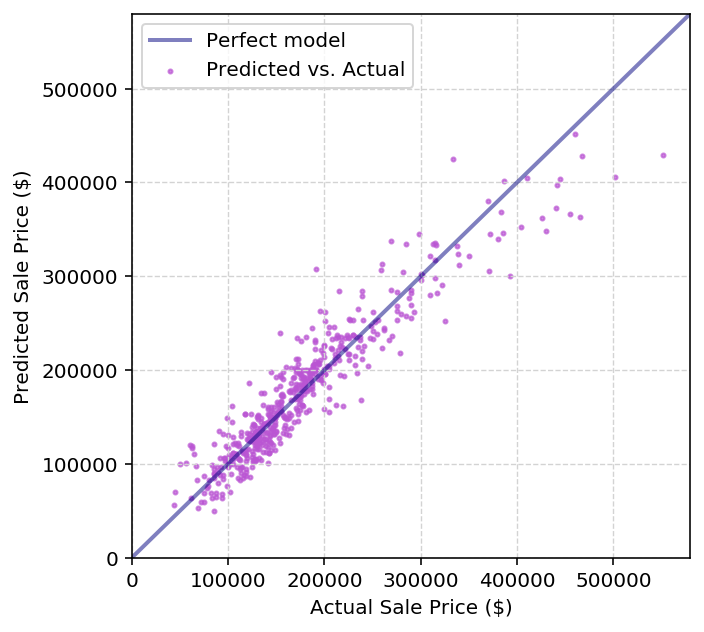

In [119]:
# Call function to plot model predictions vs actual test values
plot_y_yhat(y_val, lr.predict(X_val))

The RMSE looks normal as the training and test RMSE is about the same. Since Ridege R2 is better than the other 2, let's use Ridge. Recall that Ridge performs best searching alphas through logarithmic space (np.logspace). This may take awhile to fit.

In [120]:
# Gridsearch using RidgeCV.  Fit model and print R2 score for test data.
ridge_alphas = np.logspace(-3,5,200)
ridge = RidgeCV(alphas=ridge_alphas, cv=10)
ridge.fit(X_train, y_train)

print(f'Optimal Ridge R2 score on training data: {round(ridge.score(X_train, y_train),3)}')
print(f'Best alpha: {round(ridge.alpha_,3)}')

Optimal Ridge R2 score on training data: 0.85
Best alpha: 3.144


In [121]:
# Using the best alpha, cross validate the training data and print the mean R2 score
optimum_ridge = Ridge(alpha = ridge.alpha_)
print(f'Mean R2 score for optimal Ridge cross validation on training data:', 
      round(np.mean(cross_val_score(optimum_ridge, X_train, y_train, cv=10)),3))

Mean R2 score for optimal Ridge cross validation on training data: 0.79


In [122]:
# Fit optimum ridge on training data, and score it on the test data
optimum_ridge.fit(X_train, y_train)
print(f'R2 score of optimum Ridge on test data: {round(optimum_ridge.score(X_val,y_val),3)}')

R2 score of optimum Ridge on test data: 0.79


It's slightly better than the Linear Regression. There is likely multicollinearity in the data that "vanilla" regression overfits and has bogus coefficients on predictors. Let's see what Lasso can do.

### Lasso
Find an optimal value for Lasso regression alpha using LassoCV.
Once the LassoCV is fit, the attribute .alpha_ contains the best alpha parameter it found through cross-validation. Unlike Ridge, performs best searching for alpha through linear space (np.linspace), we can let LassoCV decide itself what alphas to use by instead setting the keyword argument n_alphas= to however many alphas you want it to search over. It is recommended to let sklearn choose the range of alphas. Setting verbose = 1.

In [123]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=0, max_iter=10000) # set verbose to 0 to disable the progress
optimal_lasso.fit(X_train, y_train)

print(optimal_lasso.alpha_)

3550.6928843265805


#### Cross-validate the Lasso  𝑅2  with the optimal alpha.

In [124]:
# Let's see whether Lasso can perfomr better than Ridge.
lasso = Lasso(alpha=optimal_lasso.alpha_)
lasso_scores = cross_val_score(lasso, X_train, y_train, cv=10)
print(lasso_scores)
print (np.mean(lasso_scores))

[0.83699764 0.80346767 0.80184714 0.80407612 0.806882   0.35170842
 0.81352224 0.87915489 0.78385213 0.7658882 ]
0.764739645482076


#### Ridge's mean R2 is still better than the vanilla LR and Lasso.
Comparing to Ridge, Lasso also deal primarily with the feature selection of valuable variables,
eliminating ones that are not useful. This also takes care of multicollinearity, but in a different way: it will choose the "best" of the correlated variables and zero-out the other redundant ones. There may also be useless variables in the data which it is simply getting rid of entirely.

#### Let's take a look at the coefficients for variables in the Lasso.
Show the coefficient for variables, ordered from largest to smallest coefficient by absolute value.

In [125]:
lasso.fit(X_train, y_train)

Lasso(alpha=3550.6928843265805, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [126]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})
lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs.head(10)

variable          coef      abs_coef
10     gr_liv_area  26481.080965  26481.080965
27          garage  14521.981752  14521.981752
26  remod_age_sold -11636.281166  11636.281166
25   age_year_sold -11102.413148  11102.413148
6    total_bsmt_sf   8534.892606   8534.892606
3     mas_vnr_area   7423.207970   7423.207970
18      fireplaces   6431.103246   6431.103246
7       1st_flr_sf   5085.543100   5085.543100
16   kitchen_abvgr  -4008.441215   4008.441215
4     bsmtfin_sf_1   2032.023565   2032.023565

In [127]:
print('Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0]))

# Hum.. Lasso did not remove any features. Not a surprise because it may be because of bulk of the features 
# were dropped during the EDA and data cleaning stage. 

Percent variables zeroed out: 0.02779132130667967


### Find an optimal value for Elastic Net regression alpha using ElasticNetCV.
We will be optimizing both the alpha parameter and the l1_ratio:
alpha: strength of regularization
l1_ratio: amount of ridge vs. lasso (0 = all ridge, 1 = all lasso)

We will use n_alphas for the alpha parameters instead of setting our own values: highly recommended!

Due to time constraint, minimal l1_ratios over cross-validation folds will be used in the search as too many ratio can take a very long time to run.

In [128]:
l1_ratios = np.linspace(0.01, 1.0, 25)
optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=0)
optimal_enet.fit(X_train, y_train)
print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

3550.6928843265805
1.0


### Cross-validate the ElasticNet  𝑅2  with the optimal alpha and l1_ratio.

In [129]:
enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)
enet_scores = cross_val_score(enet, X_train, y_train, cv=10)
print( enet_scores)
print( np.mean(enet_scores))

[0.83699764 0.80346767 0.80184714 0.80407612 0.806882   0.35170842
 0.81352224 0.87915489 0.78385213 0.7658882 ]
0.764739645482076


### No improvement from Lasso regression # Performs basically the same as lasso, which is to be expected given that l1_ratio is 1 (full lasso). Ridge is still the best of the lot.

#### Compare the residuals for the Ridge and Lasso visually

In [130]:
# Fit the ElasticNet and Ridge outside of cross_val_score
ridge.fit(X_train, y_train)
lasso.fit(X_train, y_train)

Lasso(alpha=3550.6928843265805, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [131]:
# model residuals:
ridge_resid = y_val - ridge.predict(X_val)
lasso_resid = y_val - lasso.predict(X_val)

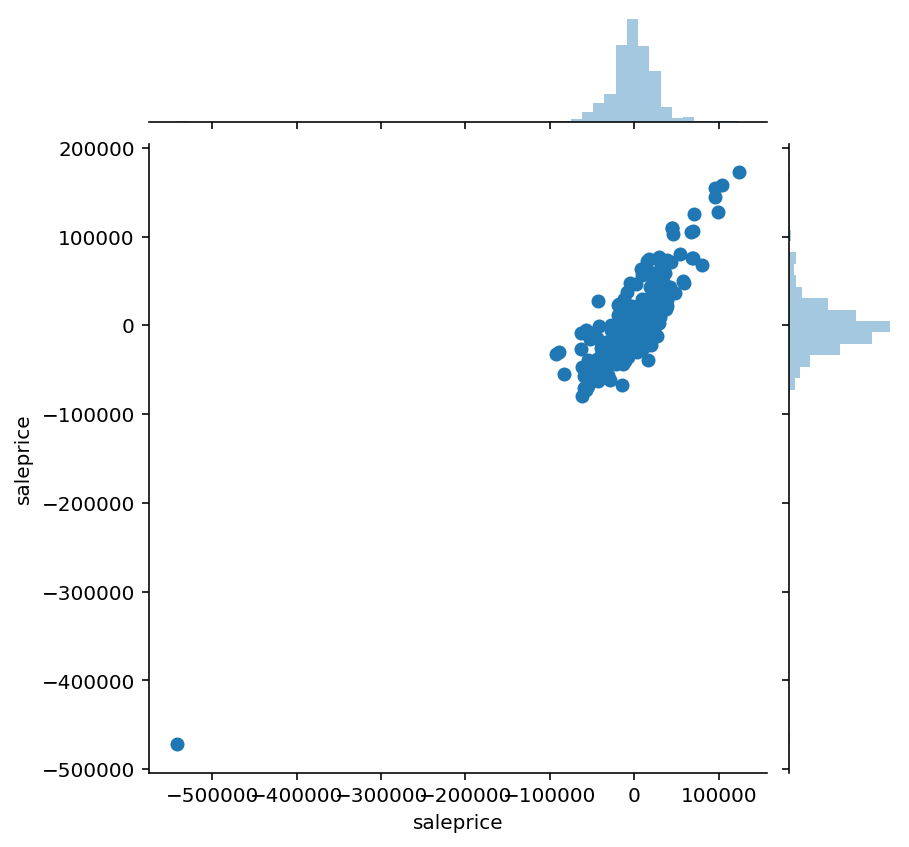

In [132]:
# Plot the residuals of Ridge and Lasso.
sns.jointplot(ridge_resid, lasso_resid);

### Let's run the validation dataset through the Ridge regression model

In [133]:
# Assign estimated sales price to variable pred.
pred = ridge.predict(X_val)

In [134]:
# Compute the R2 of the validation run. R2 looks fine as it is lower than the R2 from the 
# Ridge training (0.83219) thus, no overfitting.
r2_score(y_val, pred)

0.7904253632857383

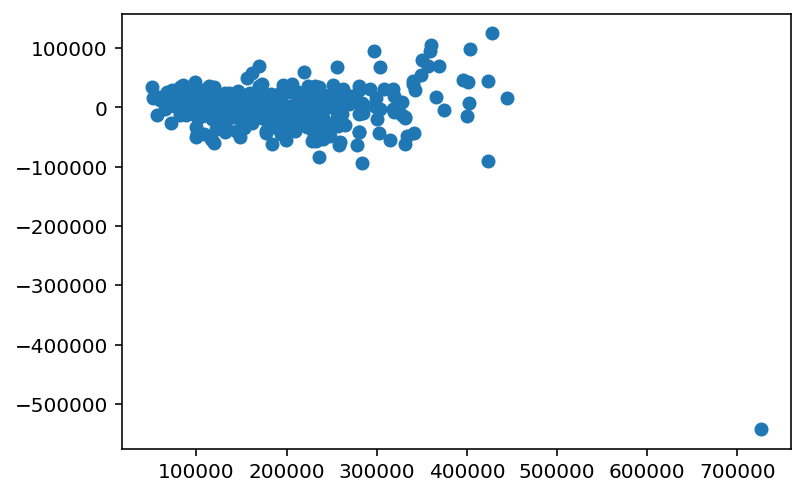

In [135]:
# Let's have some visual on residuals.
residuals = y_val - pred
plt.scatter(pred, residuals);

## The moment of truth... :)

In [136]:
# Run the test dataset through the selected model
pred = ridge.predict(test_all)

In [137]:
len(pred)

879

In [138]:
pred.shape

(879,)

In [139]:
test_id = test.iloc[:,0]

In [140]:
# Save test results in csv format in ./datasets/ sub-directory
submission = pd.DataFrame({'Id':test_id,'SalePrice':pred})
file_to_submit = Path("datasets/submission_final.csv")
submission.to_csv(file_to_submit, index=False)